v25.11.16 - PySamplingQuality.py Tutorial and short description

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy

from IPython.display import Image

import os,sys
import subprocess as SB
os.chdir('Tutorial/')

sys.path.append('../')

# I. Preface

This notebook contains a short description and two examples how to use the 

>PySamplingQuality.py

tool to investigate the sampling quality of molecular dynamics (MD) simulations using a multi-trajectory approach. Details are explained in:

    Manuscript: Quantitative assessment of molecular dynamics sampling for flexible systems
    Authors: Mike Nemec and Daniel Hoffmann
    submitted to JCTC Aug.2016
    
Here, we will use

1. a command line representation generating configuration files
1. an IPython representation

calculating the overlap of two 100ns trajectories simulated with

1. Amber14
1. Gromacs v4.6.5

This Tutorial is focused on the general options to run the quality assessment on conventional MD trajectories using mostly the default options.

## Ia) Program versions

The tool was generated and tested using:

    Python     2.7.12
    Anaconda   2.4.1 (64-bit)
    Matplotlib 1.5.1
    scipy      0.17.0
    numpy      1.10.4
    Gromacs    v4.6 | 5.1
    Amber      AmberTools14
    
__Notes:__

- Matplotlib 1.2.0 or higher is required to use the plotting tools

# II. Required pre-processing

## 1. Trajectories

The only required files are the __post-processed trajectories__, possibly the __topology__ of the protein(s), possible __reference structures__ and __PySamplingQuality.py__.

Post-processed trajectories mean, that the protein is whole, without jumps and that artifacts from periodic boundary conditions (PBC) are re-covered. Additionally, for simplicity, the water molecules and ions are deleted, because they are not part of the overlap analysis, and only every 0.1nm of the trajectories is used to make the files small.

Here, two trajectories of Met-Enkephalin (penta-peptide) simulated with Amber14

    Met_Amber1_stripped.pdb
    Met_Amber1_stripped.netcdf
    Met_Amber2_stripped.pdb
    Met_Amber2_stripped.netcdf
    Met_Amber_stripped.top

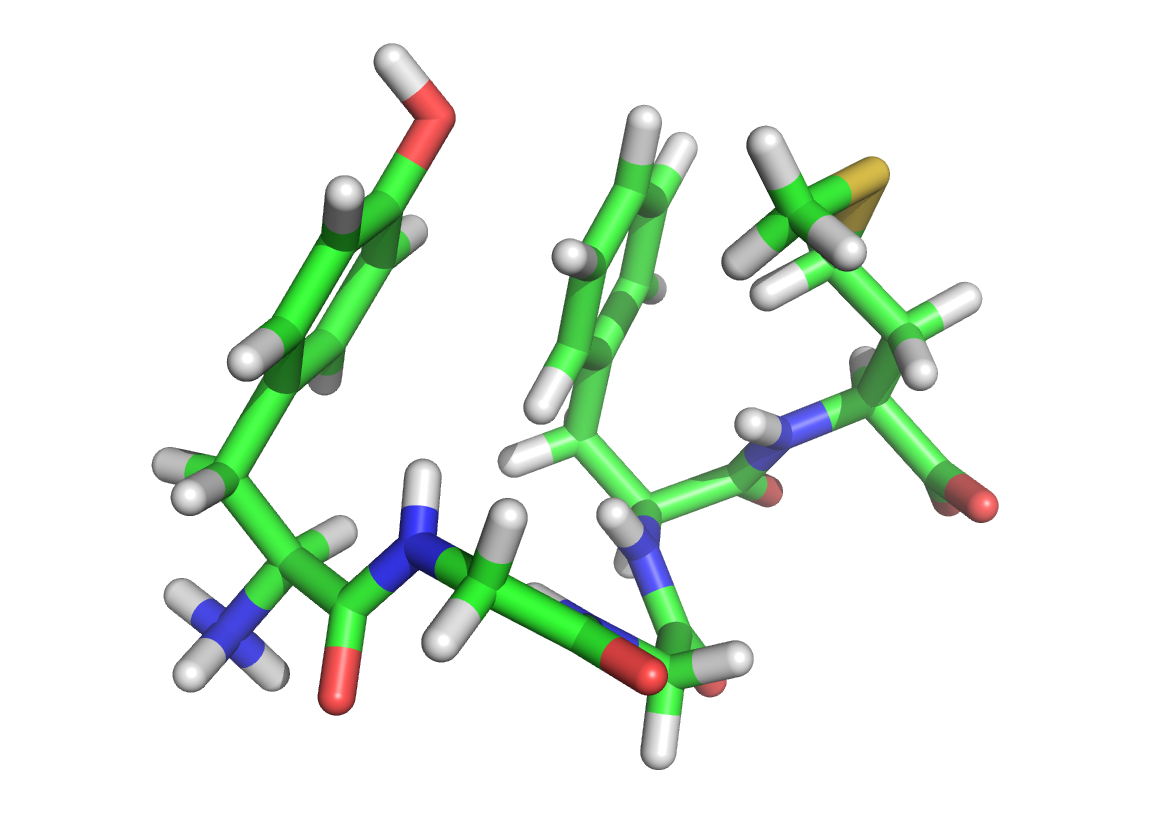

In [2]:
Image(filename='Met_struct.png', width=400)

and two trajectories of the V3-loop of HIV-1 (35 amino acids, closed by a disulfide bridge) simulated with Gromacs v4.6.5

    V3_Gromacs1_stripped.xtc
    V3_Gromacs2_stripped.xtc
    V3_Gromacs1_stripped.pdb
    V3_Gromacs2_stripped.pdb
    
are stored in 

> Trajectories/

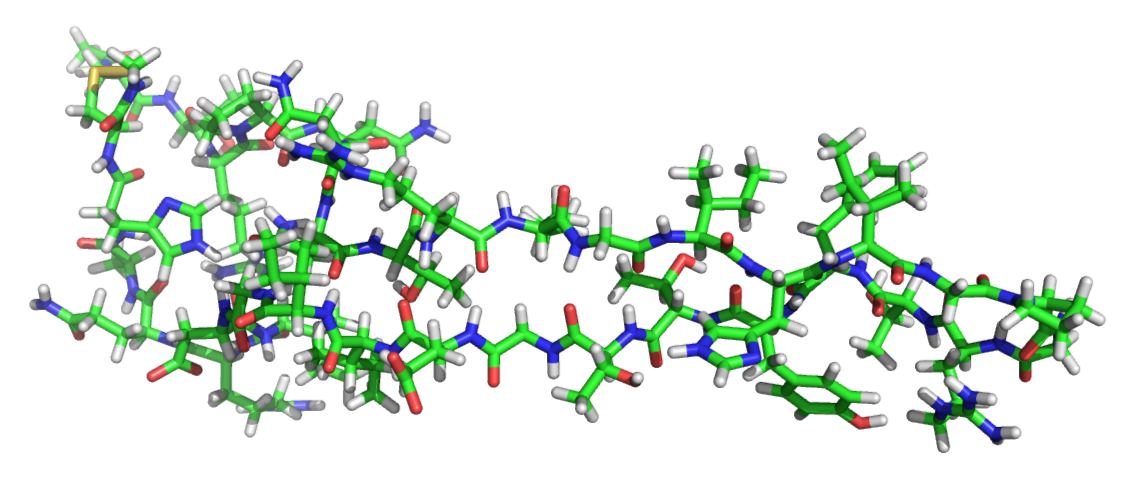

In [3]:
Image(filename='V3_struct.png', width=800)

## 2. RMSD matrices

One is able to assess the sampling quality without a __Gromacs or Amber__ installation, only using the Python tool. Then, it is necessary to generate RMSD matrices (or distance based matrices) by hand (with Python or another MD simulation analysis tool). 

RMSD matrices must be generated for every trajectory separately. Additionally, one must also generate RMSD matrices for every unique trajectory pair combination. Thus, one obtains a block matrix representation of the full RMSD matrix concatenating all trajectories. The algorithm searches for the following names:

1. if the trajectories are called

        ExampleName1.ending
        ExampleName2.ending
        ... ,
    
1. then the RMSD matrices have to be generated as

        ExampleName1_bin.dat
        ExampleName2_bin.dat
        ExampleName1_ExampleName2_bin.dat
        ... ,
where ExampleName$X$_bin.dat stores the RMSD values between all simulated structures of trajectory $X$, and ExampleName$X$_ExampleName$Y$_bin.dat stores the RMSD values between all simulated structures of trajectory $X$ against trajectory $Y$ with $X < Y$. The latter relation means, that only the upper half of the full RMSD matrix containing all trajectories needs to be stored, because it is symmetric.

Using Gromacs or Amber trajectories, the algorithm supports the generation of RMSD matrices (and references for the effectiveClustering) using Gromacs or AmberTools (full support checked for Gromacs v4.6.7 and AmberTools14).

# III. Syntax and applications

The full analysis can be done either on __command line__, 
    
1. generating default configuration files,
1. add all necessary parameters per hand
1. and re-submit the full configuration files,

or __importing the modules in IPython__ directly. 

The following modules/functions are available and will be presented, which are ordered in three main blocks:

- Overlap calculation

> Generate_RMSD_Matrices()

> determineR_using_RMSD_distributions()

> Generate_EventCurves()

> Calc_Overlap()

- Clustering

> Generate_Clustering()

> Merge_Clustering_different_Thresholds()

> Generate_Centers_GLOBAL_singles()

> Generate_CDE_to_File()

> Generate_Slope_Error()

- Visualization

> Plot_ClusterProfile()

> Plot_Slope_Error_Plateau_NrClust()

> Plot_Overlap_VS_Threshold()

> Plot_HeatMap_1vs1()

> Plot_HeatMap_as_Dendro()

> Plot_Overlap_VS_Time()

> Plot_Overlap_VS_Cluster()


The __first example__ will be done using the command line representation. The general syntax is

> python ../PySamplingQuality.py -module GenerateIn -in MODULE -out CONFIGFILE.in

> python ../PySamplingQuality.py -module MODULE     -in CONFIGFILE.in

The __second example__ will be done importing the modules with the following syntax

> import MODULE

> MODULE(options)

# IV Generating the configuration files on command line and run the analysis

The configuration files contain all necessary variables for the calculation with short descriptions. Additionally, the format syntax is indicated. All default values are automatically assigned.

Required variables have to be passed within quotes.

Afterwards, the complete configuration files are passed to generate the analysis.

## 1. Overlap calculation

For the Overlap calculation, first the RMSD matrices are generated. Then the RMSD distributions are monitored to get an overview about relevant RMSD thresholds for further calculation steps. Afterwards the EventCurves for every trajectory and finally the overlap are calculated.

The full details about the EventCurves and the Overlap definition can be found in the manuscript mentioned above. 

In short: for every (reference) trajectory frame $\kappa \in K$, the number of structures (events $e_{r,\kappa l}$) of a certain trajectory $l \in L$ within the $r$-neighborhood is monitored in EventCurves. $r$ is the threshold with $RMSD(\kappa,x) \leq r$, which is used to count the number of events which have an RMSD value smaller or equal than $r$ between the reference trajectory frame $\kappa$ and any other simulation frame $x$ of the corresponding trajectory $l$. 

The measure, if different trajectories can be found in the same $r$-neighborhood, is processed into two Overlap values, using reference trajectories $K$ and comparison trajectories $L$, where either $K \in L $ or $K \subset L$ is true: 

1. The conformational overlap $O_{conf}(K,L;r)$ gives information about, for how many reference frames $\kappa \in K$ one can found at least one occurrence of all trajectories, normalized by the total number of reference frames $n_{\kappa}$ ($O_{conf} \in [0,1]$). 
    $$O_{conf}(K,L;r) = \frac{1}{n_{\kappa}} \sum_{\kappa \in K} \delta\left(\prod_{l \in L}e_{r,\kappa l}\right), \quad \delta(x) = \begin{cases} 1 \text{ for } x \neq 0 \\ 0 \text{ else}\end{cases} $$
1. The density overlap $O_{dens}(K,L;r)$ gives information about, if the probability density is similar for the r-neighborhoods of different reference frames for different trajectories $L$ ($O_{dens} \in [0,1]$). It averages the ratio of minimal and maximal events over each reference frame $\kappa$ for each reference trajectory $k \in K$ separately. The value for all reference trajectories $K$ is then the sum over all overlap values for all individual reference trajectories $k \in K$ normalized by the number of reference trajectories $n_K$:
    $$O_{dens}(K,L;r) = \frac{1}{n_K} \sum_{k \in K} \left\langle \frac{\min\{e_{r,\kappa l} : l \in L\}}{\max\{e_{r,\kappa l} : l \in L\}} \right\rangle_k, \quad \langle . \rangle_k \text{ means the average over all $\kappa \in k$} $$

$K$ are the reference trajectories, from which the reference frames $\kappa \in K$ are taken. $L$ defines the trajectories between which the certain overlap value is calculated. $r$ is the threshold parameter.

Note that in the manuscript, there are weights defined in the "average" $\langle . \rangle_k$ which are in fact only necessary for accelerated sampling algorithms (accelerated MD (aMD) [Hamelberg et al. JCP120 2004, Sinko et al. JCTC 8 2012] or scaled MD (sMD) [Sinko et al. JPCb 117 2013]). For conventional MD (cMD), the weights are equal to one, thus the formula can be simplified with the average. Additionally, it is necessary to normalize the number of events for each trajectory to the same lengths. This step is left out here, because we will use only trajectories with the same lengths.

We need to

1. generate RMSD matrices of all trajectories and (unique) trajectory pairs
    - investigate the RMSD distributions of all trajectories
1. calculate the EventCurves
1. and finally calculate the overlap (conformational and density)
following this scheme:

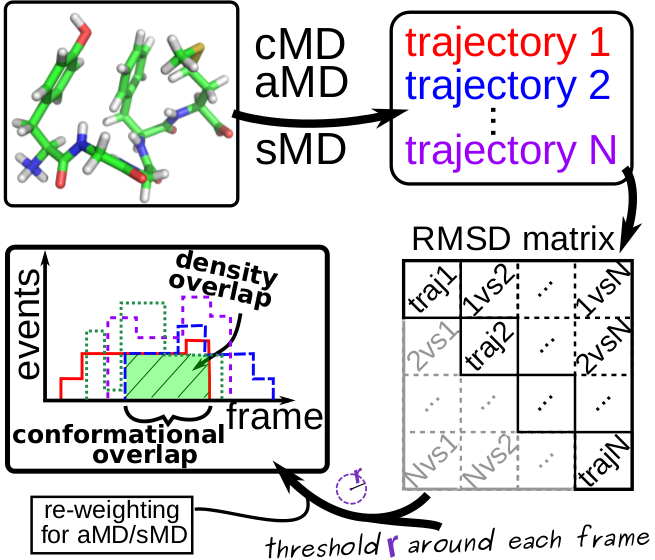

In [4]:
Image('OverlapCalculation.png', width=500)

### a) Generate configuration files

For the four steps to generate the overlap, we need at least four configuration files, which are generated by:

> python ../PySamplingQuality.py -module GenerateIn -in Generate_RMSD_Matrices -out ConfigFiles/Met_RMSDmat.in

> python ../PySamplingQuality.py -module GenerateIn -in determineR_using_RMSD_distributions -out ConfigFiles/Met_RMSDdist.in

> python ../PySamplingQuality.py -module GenerateIn -in Generate_EventCurves -out ConfigFiles/Met_Events.in

> python ../PySamplingQuality.py -module GenerateIn -in Calc_Overlap -out ConfigFiles/Met_Overlap.in

We will in total generate two additional files for the eventcurves and the overlap using different simulation time setups to analyze the influence of the simulation length.

> python ../PySamplingQuality.py -module GenerateIn -in Generate_EventCurves -out ConfigFiles/Met_Events2.in

> python ../PySamplingQuality.py -module GenerateIn -in Generate_EventCurves -out ConfigFiles/Met_Events3.in

> python ../PySamplingQuality.py -module GenerateIn -in Calc_Overlap -out ConfigFiles/Met_Overlap2.in

> python ../PySamplingQuality.py -module GenerateIn -in Calc_Overlap -out ConfigFiles/Met_Overlap3.in

First, we will take a detailed view into the first configuration file, to get an overview about the syntax and structure. Then, we will discuss the most relevant options and finally we will generate all files using the prepared configuration files.

Here, for simplicity, we generate first all configuration files and then run the analysis at once, although it is recommended to run first the RMSD distribution analysis because it gives insight into which thresholds $r$ should be used for the further overlap analysis.

### b) Explicit example of the configuration files for the RMSD matrix generation Met_RMSDmat.in

The commands above generate configuration files in 

    ConfigFiles/

and they even generate directories, which do not exist. The configuration files have all the same structure, which is visualized for __Met_RMSDmat.in__:

##### 1. header

The header contains always the information about the module (__Generate_RMSD_Matrices()__) and some short descriptions.

This is followed by the description of the module itself, containing the __version__ and necessary information.

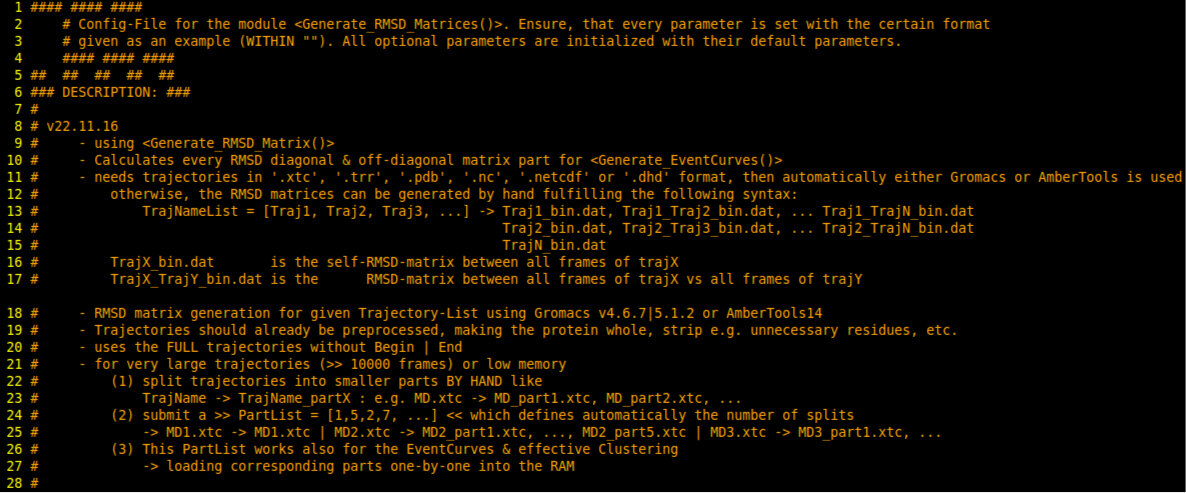

In [5]:
Image(filename='Config_Header.png', width=1000)

##### 2. default and required parameters

---
__NOTE:__

- __Double quotes have to enclose every parameter.__
        
        ""
        
- __An empty parameter/blank space is assumed as a set parameter. For a string, it generates a blank space.__

        " "
        
- __An empty string (e.g. for no directory changes or AmberHome) is submitted without blanks but single quotes enclosed by double quotes.__

        "''"
        
- __Default empty strings do not have to be changed, since they are assumed to be empty strings. E.g.__

        Program_Suffix = "''"
        
---

The header is followed by the parameters, which have to be set by hand, if no default value is present.



For the __example of the RMSD matrix generation__, the last five values are automatically set by default. They contain the following options:

1. Set an AmberHome variable to find the analysis tool __cpptraj__.
1. Set a GromacsHome variable to find the analysis tool __g_rms / gmx rms__.
1. Switch between __fitting__ all structures on top of each other before RMSD matrix calculation or not.
1. Set a possible __suffix__ to the Gromacs analysis modules (see: Gromacs installation http://www.Gromacs.org/Documentation/Installation_Instructions_4.6).
    - if you did not specify a suffix during the Gromacs installation, for Gromacs v4.6.7 your modules should be called e.g. 
            
            g_rms         ->   Program_Suffix = "''"
    - if you did specify a suffix, they should be called e.g. 
        
            g_rms_suffix  ->   Program_Suffix = "_suffix"
        
1. Tell the program, if trajectories are __split into different parts__ due to memory reasons.

__By default__, it is assumed, that the Home-variables are set in your environmental variables, that the structures are fit using translational and rotational superposition, that a (possible) Gromacs installation does not contain any further program suffix and that the trajectories are not split. These parameters can be left unchanged in our example, except that the path of AmberHome is set explicitly.

The __Fit__ is usually done, if the whole protein is part of the overlap analysis, i.e. the structure conformations are the indicator, how well the protein is sampled. In this example, it shall be detected, if the single protein system is sampled sufficiently. For a complex system of multiple proteins or a protein-ligand system, it might be more relevant, to detect and analyze the attachment of the ligand binding. This issue is discussed in section __VI. Protein-ligand systems or complexes__ below.

Additionally, they are __nine parameters, which have to be set__ by hand. In this example, there are strings, an int/float and a list, which have to be set. The parameter types are given in angle brackets. 

Strings, ints and floats are just inserted as they are. Lists are always separated by a free space (e.g. "Name1 Name2 Name3 Name4") whereas lists with only one input does not contain a free space. There are always format examples in the same line as the parameter followed by #.

Furthermore, every parameter has an __own description__ and always a __specific example__, how a correct input will look like.

__In this example__, there are four directories, a list of trajectory names, the structure topology name, a timestep, which frames of the trajectories are taken into account and two selections, which atoms are used for the RMSD calculation.

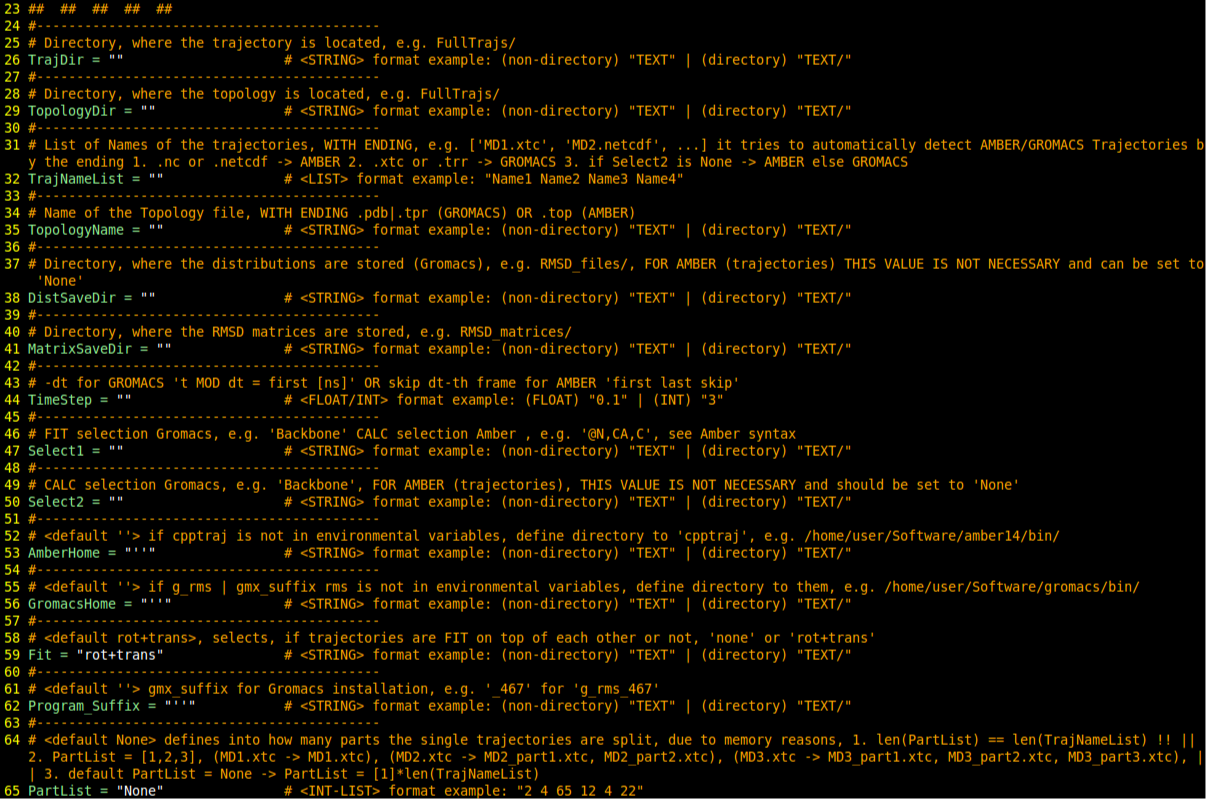

In [4]:
Image(filename='Config_Parameters.png', width=1000)

##### 3. complete configuration file

In this tutorial, the trajectories and topology file are located in 

    Trajectories/
    
and the RMSD matrices are stored in 

    RMSD_matrices/
    
The trajectories were pre-processed, thus we now use every time frame of the trajectory setting

    TimeStep = "1"
    
and using only the backbone atoms ($N, C_{\alpha}, C$) for the RMSD calculation. 

Note, that the parameter __TimeStep__ allows the user to extract a certain part of frames from the trajectories, for example every 10th frame. The syntax differs significantly if you are using the Gromacs tool __g\_rms__ (which is automatically applied for Gromacs trajectories with endings _.xtc_, _.trr_ or _.pdb_) or AmberTools __cpptraj rms__ (which is automatically applied for Amber trajectories with endings _.nc_, _.netcdf_ or _.dhd_). For Amber trajectories, __TimeStep__ corresponds to the extraction frequency of frames, i.e. every __TimeStep-th__ frame is taken. For Gromacs trajectories, __TimeStep-th__ corresponds to a certain time $\Delta t$ (in [ns]), e.g. TimeStep=0.1 means, that starting from the first frame, every 100ps is taken. 

Furthermore, the topology and the trajectory names must contain the data file endings for the RMSD Matrix generation, which is not necessary in the other modules. Here, the program tries to detect automatically Gromacs or Amber trajectories.

Finally, directories are always submitted with their corresponding slash, which can be seen in the following figure.

Now, the configuration file is complete and can be used for the file generation.

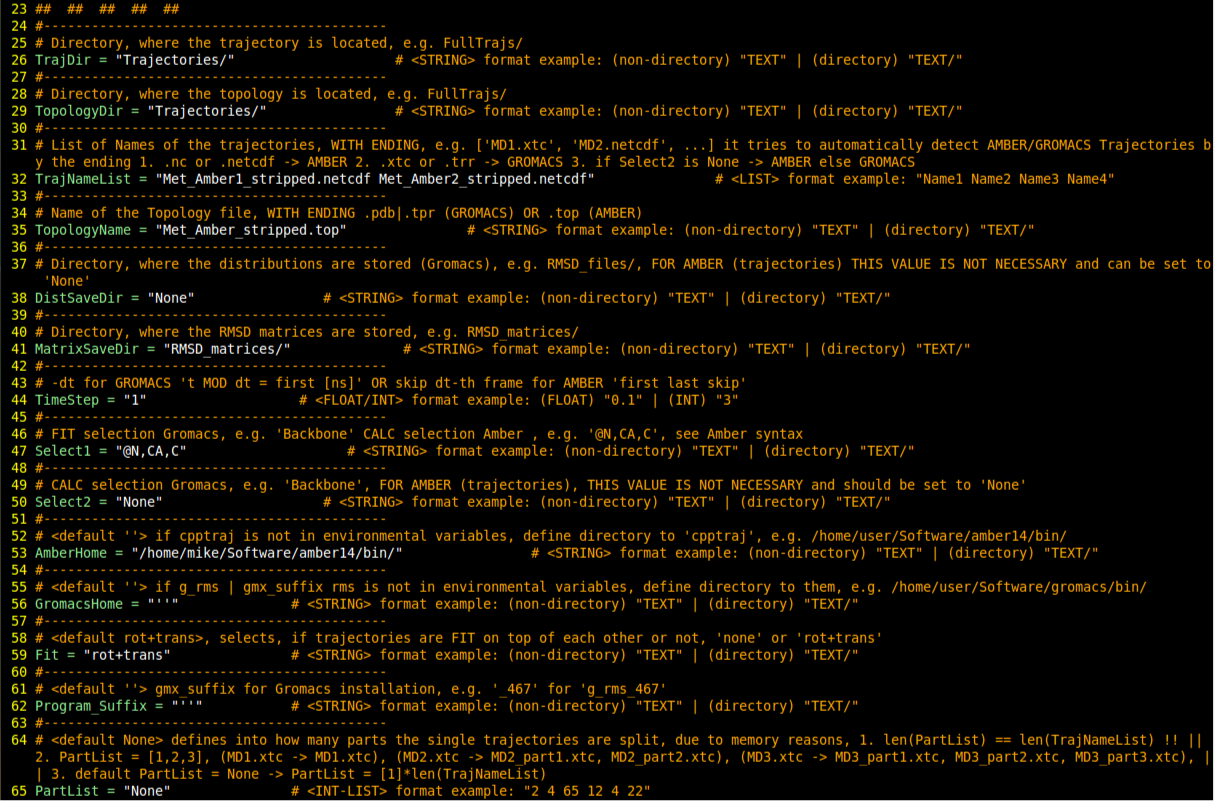

In [5]:
Image(filename='Config_Complete.png', width=1000)

### c) Relevant options for the other configuration files

##### 1. Met_RMSDdist.in

The necessary parameters for configuration file of the RMSD distribution analysis are self-explanatory. We only change the __Percent__ parameter to __0.99__, to obtain the limits which describes 99% of the amount of the RMSD values. Both 0.05 % tails are treated as outliers. Usually, the RMSD limits representing the 99% of the RMSD distributions will be used to define relevant $r$ values, where the overlap (density and conformational) will be zero for the lower bound and one for the upper bound. This interval will also be used to plot the overlap as function of the threshold and calculate the averaged overlap by integrating the curve in these $r$ limits.

##### 2. Met_Events.in, Met_Events2.in, Met_Events3.in

For the eventcurve generation, we use a __ThredholdList__ of

    ThresholdList = "0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4"
    
which are relevant parameters with respect to the RMSD distributions shown below. The __lengths__ of both trajectories are 1000 frames each.

Then, there are two further necessary parameters __MaxNumberLines__ and __BinFile_precision__. MaxNumberLines directly inflicts the memory usage because it defines how many lines of the RMSD matrix (blocks) are loaded at once. Because the RMSD matrices have only a size of 1000x1000, it can be loaded completely, setting __MaxNumberLines = "1000"__

The parameter __BinFile_precision__ represents for Gromacs trajectories the format type of the generated RMSD matrices in binary format, i.e. "float32" for a single or "float64" for a double precision installation. Here, we use only Amber trajectories, thus this value has to be set to "None".

Furthermore, we want to investigate three different simulation time lengths, 30ns, 60ns and 100ns. Thus one has to change __StartFrame__ and __EndingFrame__ to the corresponding values. The trajectories contain each 100ns and 1000 frames, whereas the default value EndingFrame="NP.infty" means automatically the last frame. Thus we set for the free configuration files 

    StartFrame = 0,   EndingFrame="NP.infty"
    StartFrame = 0,   EndingFrame="600"
    StartFrame = 0,   EndingFrame="300"
    
which refer to simulation time lengths of 100ns, 60ns and 30ns starting always from the beginning of the trajectory.

All other values are either self-explanatory or only necessary for re-weighting, if enhanced sampling algorithms (aMD [Hamelberg et al. JCP120 2004, Sinko et al. JCTC 8 2012] or scaledMD [Sinko et al. JPCb 117 2013]) were used. 

__For re-weighting:__

One has to specify, which of the submitted trajectories was sampled with enhanced sampling algorithms __aMD\_Nrs/sMD\_Nrs__ (numbering starting from 1) and also specify, where possible aMD.log files from Amber are located, or which re-scaling factor $\lambda$ was used for scaledMD trajectories.

For example, if you have three trajectories with

    TrajNameList = "cMD.netcdf aMD1.netcdf aMD2.netcdf sMD.netcdf" ,
    
where the names correspond to the sampling algorithm cMD, aMD or sMD, you must specify

    aMD_Nrs = "2 3"
    sMD_Nrs = "4" ,
 
which marks that the second and third trajectories were calculated with aMD and the fourth with sMD. Otherwise, these trajectories would be treated as cMD runs. To re-weight aMD trajectories, one needs the acceleration potentials $\Delta V_{j}$ for the corresponding frames $j$, which are generated by the Amber software. By default, they are stored in a text file called __aMD.log__ in the simulation folder. The written frames correspond one-by-one to the frames in the original trajectory. If you pre-process your trajectory by stripping special frames, this must also be done for the aMD.log file. __WeightStep__ must also correspond to the TimeStep parameter to extract the same frames, thus WeightStep will usually be set to the same value as TimeStep. Additionally, you need to specify the directory and the name of the aMD.log file for each aMD trajectory in the same order they are given to TrajNameList. __aMDlogName__ must have the same order and length as aMD_Nrs, whereas __aMDlogDir__ must either have only one entry, then this directory is assumed to contain all aMD.log files, or also have the same length as aMD_Nrs. A possible input would be

    aMDlogDir  = "Directory1/ Directory2/"
    aMDlogName = "aMD.log aMD.log" ,
    
then the second trajectory is re-weighted with weights found at _Directory1/aMD.log_ and the third with weights found at _Directory2/aMD.log_. The last necessary input parameter is the __AmberVersion__, which is by default set to 'Amber14'. For 'Amber14', the last two columns of aMD.log are stored in _kCal/mol_, whereas for 'Amber12' they are stored in $k_B T$ (see http://ambermd.org/tutorials/advanced/tutorial22/section3.htm). If your Amber version uses different units, you must use the proper selection of the AmberVersion and possibly change the units per hand.

Finally, the parameters __aMD\_reweight__ and __Iterations__ switch between different re-weighting algorithms and specify the number of iterations for the mean-field (MF) re-weighting approach. __Lambda__ defines the re-scaling factor which was applied for all sMD runs.

##### 3. Met_Overlap.in, Met_Overlap2.in, Met_Overlap3.in

Finally, the configuration files for the overlap contain only one complicated parameter, which is the __CompareList__. CompareList directly corresponds to the comparison trajectories $L$ defined in the overlap equations $O_.(K,L;r)$. This defines the list, which trajectories are compared with each other. It is possible, to use groups of trajectories, if one wishes to compare concatenated trajectories with another subset. These trajectories must be enclosed by the first square brackets, meaning that the eventcurves for these trajectories are combined. The second (round) brackets, defines which groups are compared with each other, for instance the overlap can be calculated between group1 vs group2 vs ... vs groupN. The last square brackets define, if multiple overlap analysis are done at once and stored in one file in multiple ascending columns.

The example

    CompareList = "[([1,2,3],[8]), ([20],[32]), ([1,8,12],[2,3,4])]"
    
will result in three different overlap measures:

1. Trajectories 1,2 and 3 are concatenated into one super-trajectory which is then compared with trajectory 8 and the corresponding overlap is measured and stored in columns 2,3,4 and 5 of the overlap file.
1. Trajectory 20 is compared with trajectory 32 and the corresponding overlap is stored in columns 6,7,8 and 9.
1. Trajectories 1,8 and 12 are concatenated into one super-trajectory identically to the concatenation of trajectories 2,3 and 4 into another super-trajectory. Afterwards these two super-trajectories are compared and the corresponding overlap values are stored in columns 10,11,12 and 13. 

See the overlap file description discussed in below.

Here, we have only two trajectories, thus we calculate the overlap between the first and the second trajectory

    CompareList = "[([1],[2])]"

Furthermore, the parameter __EventNames__ must match the name of the eventcurve generated previously.

For re-weighting, __WeightDir__ is in this case not mandatory the same as aMDlogDir. In the folder submitted by __WeightDir__, the weights are located, which were generated during the call of __Generate\_EventCurves()__ and are usually stored in the folder __Weights/__ which is located in the same directory with the EventCurves.

### d) Running the analysis and generate all files

Now, the files can be generated by 

> python ../PySamplingQuality.py -module Generate_RMSD_Matrices -in ConfigFiles/Met_RMSDmat.in

> python ../PySamplingQuality.py -module determineR_using_RMSD_distributions -in ConfigFiles/Met_RMSDdist.in

>> python ../PySamplingQuality.py -module Generate_EventCurves -in ConfigFiles/Met_Events.in

>> python ../PySamplingQuality.py -module Generate_EventCurves -in ConfigFiles/Met_Events2.in

>> python ../PySamplingQuality.py -module Generate_EventCurves -in ConfigFiles/Met_Events3.in

>> python ../PySamplingQuality.py -module Calc_Overlap -in ConfigFiles/Met_Overlap.in

>> python ../PySamplingQuality.py -module Calc_Overlap -in ConfigFiles/Met_Overlap2.in

>> python ../PySamplingQuality.py -module Calc_Overlap -in ConfigFiles/Met_Overlap3.in

which generates RMSD matrices

    RMSD_matrices/Met_Amber1_stripped_bin.dat
    RMSD_matrices/Met_Amber2_stripped_bin.dat
    RMSD_matrices/Met_Amber1_stripped_Met_Amber2_stripped_bin.dat
    
and the RMSD distributions beforehand

    RMSD_distributions/Met_Amber_dist.pdf

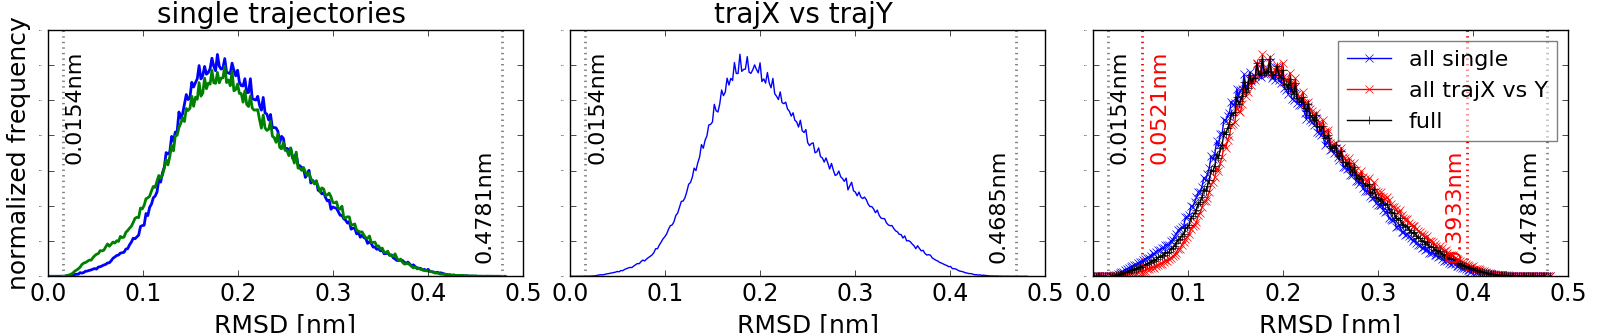

In [8]:
Image(filename='RMSD_distributions/Met_Amber_dist.png', width=1000)

The RMSD distributions of every single trajectory (left), of all trajectory pairs (middle) and the concatenated cases (right) give insight which thresholds for the overlap calculation or cluster generation are relevant. Here, the largest frequency is at RMSD = 0.2nm, showing that there are a lot of structures separated by 0.2nm and possibly forming independent clusters. Furthermore, below a threshold of $r < 0.05$nm, the overlap is trivially zero, and $r > 0.4$nm, the overlap must be 1, because you assume that all structures are identical (using the coarse resolution of $r > 0.4$nm). Thus the threshold $r$ should be set to a relevant value in the first half of the RMSD distribution curves, to obtain a good resolution, which is not too fine ($r < 0.05$nm) and not too coarse ($r > 0.4$nm). But the choice depends on the system and the scientific question (see the protein-ligand discussion below).

__The eventcurves__

    EventCurves/Met_Amber_0-1000_noWeight.npy
    EventCurves/Norm_Met_Amber_0-1000_noWeight.txt
    EventCurves/Met_Amber_0-600_noWeight.npy
    EventCurves/Norm_Met_Amber_0-600_noWeight.txt
    EventCurves/Met_Amber_0-300_noWeight.npy
    EventCurves/Norm_Met_Amber_0-300_noWeight.txt
    
are stored alongside with the normalization files, which contain the amount of involved frames for each trajectory, if the trajectory must not be re-weighted. The events as function of the frames are stored in a python binary format, and can be loaded in python via

    numpy.load('EventCurves/Met_Amber_0-1000_noWeight.npy') .

In [9]:
EventCurve1 = numpy.load('EventCurves/Met_Amber_0-1000_noWeight.npy')

print EventCurve1.shape
print EventCurve1

(2000, 18)
[[   0    1    1 ...,  778  993  983]
 [   1    1    1 ...,  997 1000 1000]
 [   2    1    1 ..., 1000 1000 1000]
 ..., 
 [ 997    2    0 ...,  992 1000 1000]
 [ 998    2    2 ...,  974 1000  999]
 [ 999    2    1 ...,  999 1000 1000]]


The columns of the eventcurves correspond to the columns of the normalization files, which are stored in txt-files. The first column refers to the frame of a given trajectory, the second column means the trajectory number numbered consecutively. The third to last columns are always storing the number of events for trajectory 1 - n for each threshold in ascending order. Thus one can plot event profiles for both trajectories.

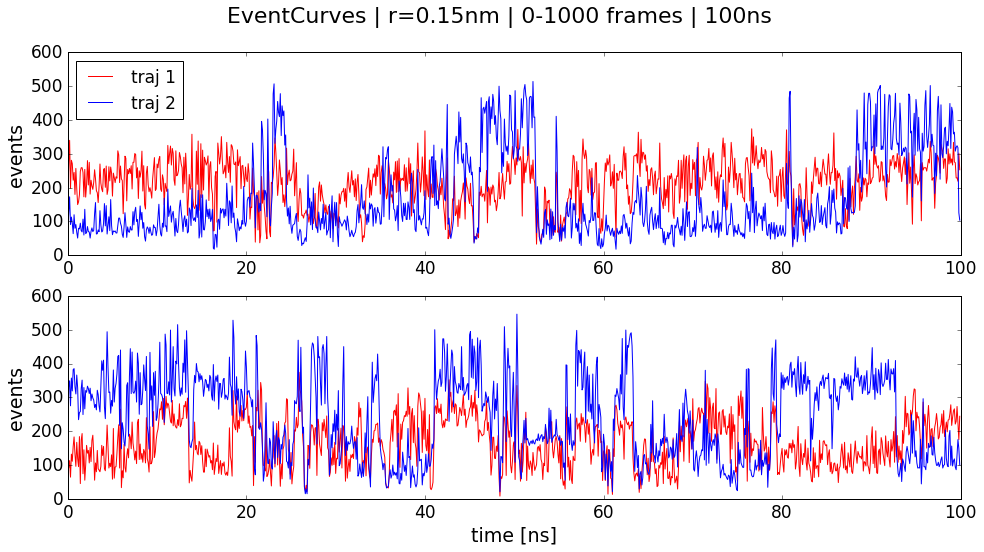

In [10]:
fig = plt.figure(figsize=(16,8));
plt.suptitle('EventCurves | r=0.15nm | 0-1000 frames | 100ns', fontsize=22);
plt.subplot2grid( (2,1), (0,0) );
plt.plot(EventCurve1[0:1000,0]/10., EventCurve1[0:1000,6], 'r-'); plt.yticks(fontsize=17); plt.xticks(fontsize=17);
plt.plot(EventCurve1[0:1000,0]/10., EventCurve1[0:1000,7], 'b-'); plt.ylabel('events', fontsize=19);
plt.legend(['traj 1', 'traj 2'], fontsize=17, loc=0)
plt.subplot2grid( (2,1), (1,0) );
plt.plot(EventCurve1[1000:2000,0]/10., EventCurve1[1000:2000,6], 'r-'); plt.yticks(fontsize=17);
plt.plot(EventCurve1[1000:2000,0]/10., EventCurve1[1000:2000,7], 'b-'); plt.ylabel('events', fontsize=19);
plt.xticks(fontsize=17); plt.xlabel('time [ns]', fontsize=19);

The event profiles give an insight about, how the trajectories are distributed over the simulated conformations, but also give information about where large or small potential areas are (probably) located. The figures illustrate the event curves for both trajectories at r=0.15nm whereas the x-axis shows the reference frames of trajectory 1 (top) and trajectory 2 (bottom). The events give the number of neighbors in the r-neighborhood for the corresponding trajectory with respect to the specific reference structure here denoted as a certain time point of the simulation.

One can see, that on some parts, both curves have the same density of points around the reference, and that there seem to be a large potential at around simulation time 47ns (upper figure) and 28ns (lower figure), where both trajectories have only few events. But one can also identify regions, where the sampling is not perfect and the number of events deviate between both trajectories.

__The overlap results__ are stored in 

    Overlap/Overlap_Met_Amber_0-1000_noWeight.txt
    Overlap/Overlap_Met_Amber_0-600_noWeight.txt
    Overlap/Overlap_Met_Amber_0-300_noWeight.txt
    
for different simulation time lengths. The format of the files is the following: 

- GroupNr, which defines the reference trajectory (set) $k \in K$, which takes by default all trajectories defined by the _CompareList_. Here GroupNr is 1 and 2 due to CompareList = [([1], [2])]. Note that the group number starts always from 1, just monitor the corresponding entry in the CompareList
- Threshold is the $r$-neighborhood definition
- Then, there are always 4 columns for each CompareList tupel, which corresponds the choice $L$
    1. densO: density overlap $O_{conf}(k,L;r)$ for the reference trajectory (set) $k$.
    1. Err: the standard deviation between all minimal vs maximal events ratios for each reference frame $\kappa$ of the reference trajectory $k$, to obtain the information about the variation of different event curves.
    1. confO: number of reference frames $\kappa \in k$, where at least one occurrence of all trajectories $L$ is present.
    1. TotFrame: total number of reference frames $\kappa$, which is used to normalize the conformational overlap value between zero and one.

The conformational overlap for all reference trajectories $K \in L$ is then the sum of __confO__ divided by the sum of __TotFrame__. The corresponding density overlap is the average over all single groups $k$ of __densO__. For $K \subset L$, one can manually decide, for which reference trajectories one wants to calculate or monitor the overlap.

The overlap values give for different reference trajectories the possibility to obtain a distribution and give the information about the variation of the measures. If the sampling is sufficient, than the overlap values will give the same results for different reference trajectories, because the densities in each $r$-neighborhood is the same, independent of the reference. If the sampling is not sufficient, and one trajectory samples for instance only a subset of another trajectory, the overlap might be larger for the first reference trajectory but small for the second. This can be used for error handling by plotting the limits or percentiles, because the underlying distributions of the overlap values and eventcurve ratios are typically unknown. The percentiles are obtained by a linear interpolation between points.

The overlap results are visualized below using the plotting modules, while by default the 1st and 3rd quartiles are used as error bars of overlap values of different reference trajectories $k$. Because here always only two values are present, the lower and upper limits are shown using __Percentile1=0__ and __Percentile2=100__.

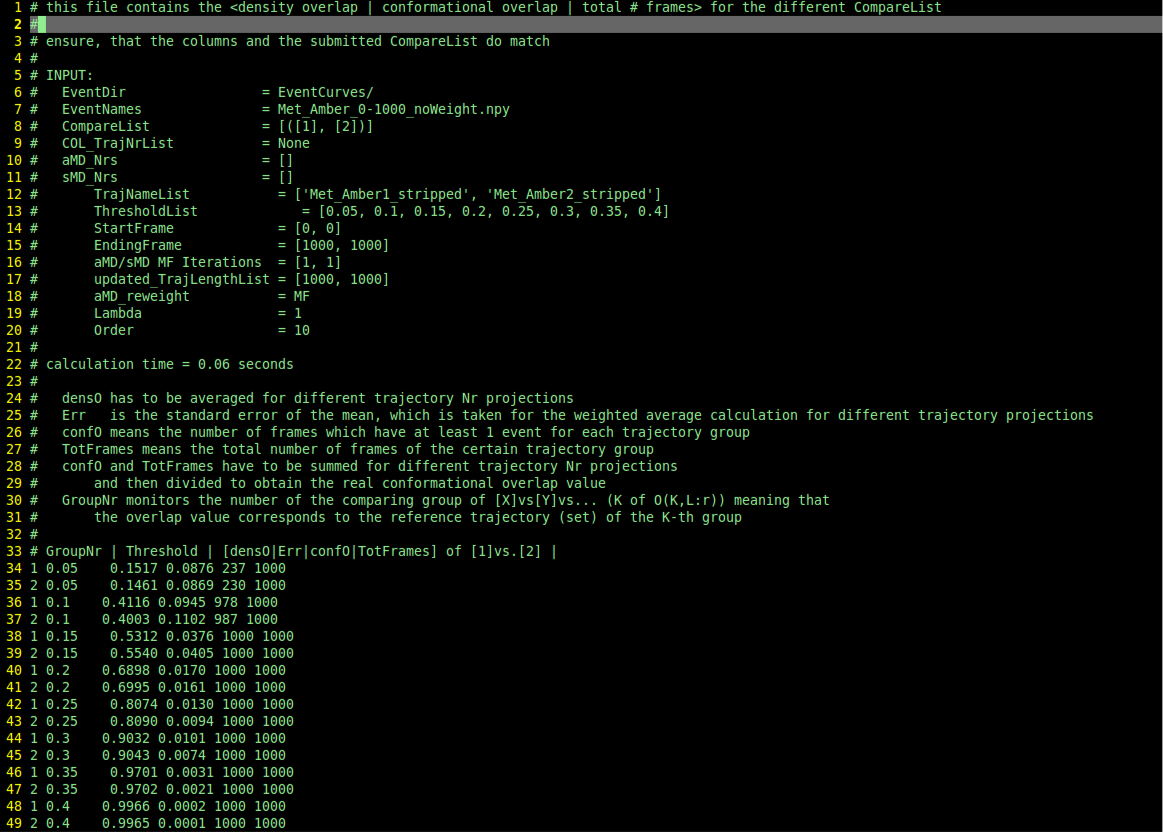

In [2]:
Image('OverlapFile.png', width=1000)

## 2) Clustering

The effectiveClustering uses the generated RMSD matrices from Generate_RMSD_Matrices(). Additionally, it is possible, to submit a reference structure (e.g. a crystal structure), to which the RMSD values are calculated. Then the closest structure to this reference is taken as starting point (first centroid $C_1$) of the clustering. Otherwise, the first frame of the first trajectory is used. 

The algorithm is described in detail in the manuscript. In short, the structures are partitioned based on the RMSD values, where centroids are assigned by the threshold $r$. The second centroid $C_2$ is the closest frame outside the $r$-neighborhood related to the RMSD-radius $r$. All frames within the RMSD-radii to already defined centroids are discarded. Then these centroids are merged by their average distance to each other forming an auxiliary center. The next centroid $C_3$ is then the closest frame outside the RMSD-radius $r$ to the auxiliary center. Then the auxiliary centroid and the new centroid are merged to a new auxiliary center as before, and the former steps are repeated until no new cluster is found. Finally, all frames which are no centroids are assigned to their closest cluster centroid. 

The clustering can either be done for every trajectory separately (Local), or on all concatenated trajectories (Global). For the latter option, single clustering for each trajectory can be extracted detecting all centroids where at least one structure of the corresponding trajectory is present.

Afterwards, the cluster vs. time and cluster distribution entropy vs. time can be visualized.

Every clustering depends on a specific threshold $r$, which are not calculated at once because it is not easily parallelizable. Clustering files with different thresholds $r$ can be merged together to be analyzed at once.

We will generate the following analysis:

1. Cluster the trajectories (threshold r = 0.1nm).
1. Cluster the trajectories (threshold r = 0.15nm).
1. Merge both clusterings together into one file.
1. Extract single trajectory clustering from the (Global) concatenated trajectory case.
1. Extract the Cluster Distribution Entropy (CDE) and Nr of Clusters vs. simulation frames.
1. Calculate the slopes for the CDE and Nr of Clusters vs. simulation time.

## a) Generate configuration files

To run the clustering, we will produce six configuration files by:

> python ../PySamplingQuality.py -module GenerateIn -in Generate_Clustering -out ConfigFiles/Met_Cluster_R0.1.in

> python ../PySamplingQuality.py -module GenerateIn -in Generate_Clustering -out ConfigFiles/Met_Cluster_R0.15.in

> python ../PySamplingQuality.py -module GenerateIn -in Merge_Clustering_different_Thresholds -out ConfigFiles/Met_Merge.in

> python ../PySamplingQuality.py -module GenerateIn -in Generate_Centers_GLOBAL_singles -out ConfigFiles/Met_GLOBAL_singles.in

> python ../PySamplingQuality.py -module GenerateIn -in Generate_CDE_to_File -out ConfigFiles/Met_CDE.in

> python ../PySamplingQuality.py -module GenerateIn -in Generate_Slope_Error -out ConfigFiles/Met_Slope.in

Here, we will generate two clusterings with threshold $r=0.1$nm and $r=0.15$nm using the full trajectories. Both trajectories are clustered at once, meaning that effectively they are concatenated and a global partition will be applied. This allows one to compare the results and number of found clusters clearly. Additionally, we apply for demonstration reasons a reference PDB structure, which is in fact the starting structure for the second trajectory. Thus, we already know, that the 1001st structure will be the first cluster centroid, which can be verified in the clustering profiles.

Afterwards, both clustering files will be merged to obtain one file for all/both threshold parameters. One only needs to ensure, that the input in __Met_Merge.in__ match the clustering file names.

Then, single clusterings are extracted from the global clustering, which involves all concatenated frames of all involved trajectories. 

The cluster distribution entropy (CDE) will also be extracted from the global clustering profile, with selecting the __Case = "GLOBAL_singles"__ to calculate the CDE for every trajectory separately, but using the global partitioning. To investigate only single trajectories, it is also possible to calculate a clustering for every trajectory separately, and then calculate the CDE, to obtain the best unique partitioning just for one trajectory.

The slopes then uses the CDE file to calculate the slopes for the last three frame cases specified by the __SlopeTimeArray__ parameter. Note, that the argument symbolizes number of frames, not a specific time. Additionally, the __X_NormFactor__ normalizes the x-axis, corresponding to the frames respectively to the simulation time. A factor of __1000__ (default) means, that the CDE or number of clusters is assumed to raise in the next 1000 steps by the calculated slope.

### b) Running the clustering and generate all files

The clustering is generated by 

> python ../PySamplingQuality.py -module Generate_Clustering -in ConfigFiles/Met_Cluster_R0.1.in

> python ../PySamplingQuality.py -module Generate_Clustering -in ConfigFiles/Met_Cluster_R0.15.in

for two different thresholds $r$ and then merged into one file by 

> python ../PySamplingQuality.py -module Merge_Clustering_different_Thresholds -in ConfigFiles/Met_Merge.in

One obtains beforehand an RMSD curve for all concatenated trajectories with respect to the reference, which is in this case simply the first structure of the second trajectory. Thus the RMSD value to this (1001st) frame is zero and will be taken as first centroid. 

There are two files which store the clustering results: First, the clustering profile is stored, which gives information, which cluster the specific frame belongs to (__PROF__), with the corresponding distances, next closest centroid (__nextC__) and the farthest centroid (__farthC__). 

    Clustering/Met_Amber_R0.1-0.15_0-1000_GLOBAL.txt

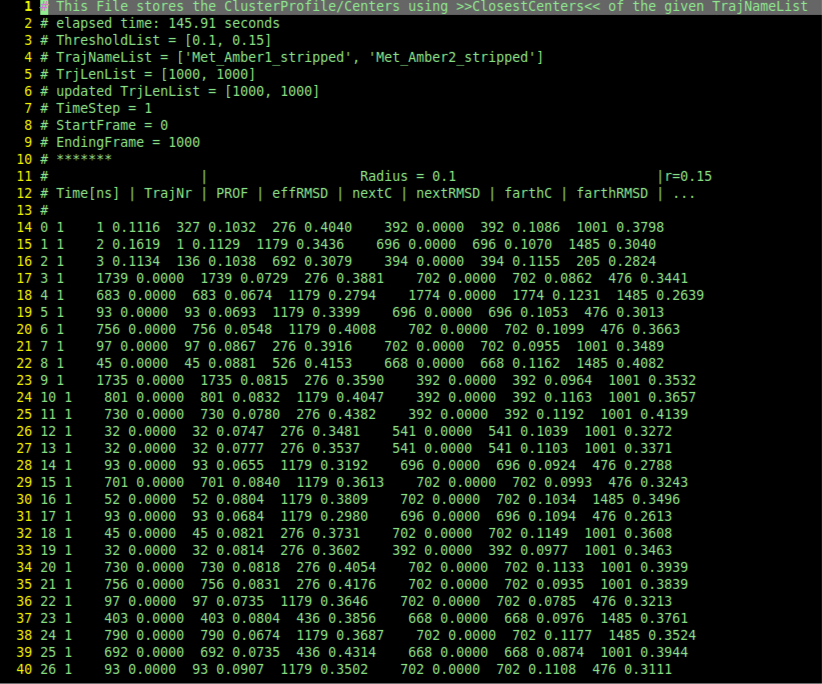

In [12]:
Image('ClusterProfile.png', width=700)

Second, the number of clusters and the corresponding cluster centroids are stored in

    Clustering/Met_Amber_R0.1-0.15_0-1000_Centers_GLOBAL.txt .

In the latter file, one can see that the 1001st frame indeed is the first detected centroid, and that there are detected 164 clusters for $r=0.1$nm and 23 clusters for $r=0.15$nm combining both trajectories.

Clusterings for each trajectory are extracted by

> python ../PySamplingQuality.py -module Generate_Centers_GLOBAL_singles -in ConfigFiles/Met_GLOBAL_singles.in

whereas only the centroid file is generated, which contains the information which and how many centroids do belong to the corresponding trajectory

    Clustering/Met_Amber_R0.1-0.15_0-1000_Centers_GLOBAL_singles.txt ,
 
the profiles stay unchanged.

Finally the CDE and the corresponding slopes are calculated

> python ../PySamplingQuality.py -module Generate_CDE_to_File -in ConfigFiles/Met_CDE.in

> python ../PySamplingQuality.py -module Generate_Slope_Error -in ConfigFiles/Met_Slope.in

obtaining
    
    Clustering/CDE_Met_Amber_R0.1-0.15_GLOBAL_singles.txt
    Clustering/Slope_Met_Amber_R0.1-0.15_GLOBAL_singles.txt
    
The CDE file contains the information, how many clusters are found in a certain simulation time and how the distribution entropy for these clusters evolves. There are also normalized values for better comparison.

__Note:__

The cluster distribution entropy (CDE) as function of the simulation time can also be re-weighted with the corresponding aMD/sMD weights specifying

- the directory, where the Weights are located
- which trajectory (number) is sampled with aMD or sMD (the trajectory number starts from 1 and corresponds to the TrajNameList stored in the clustering profile file)
- the re-weighting algorithm for aMD ('Exp' or 'McL' or 'MF')
- the number of iterations used for the mean-field (MF) weight generation
- the re-scaling factor $\lambda$ for sMD
- and the order for the MacLaurin series expansion, if the re-weighting algorithm is 'McL'.

These parameters are already discussed above in more detail.

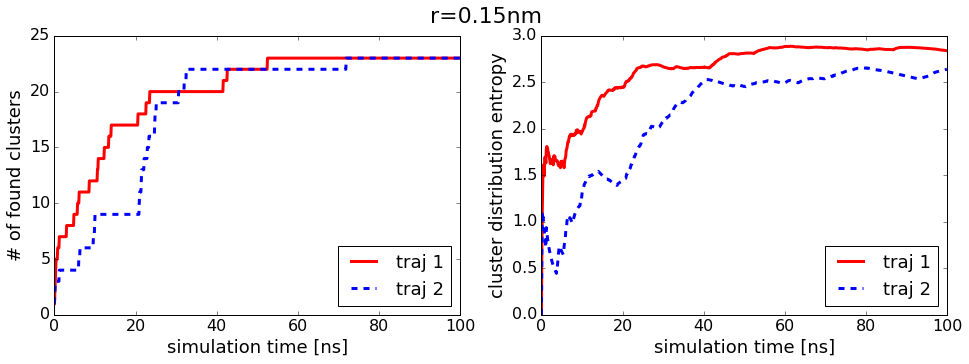

In [13]:
CDE = numpy.genfromtxt('Clustering/CDE_Met_Amber_R0.1-0.15_GLOBAL_singles.txt')

fig = plt.figure(figsize=(16,5))
#-----
plt.subplot2grid( (1,2), (0,0) ); plt.suptitle('r=0.15nm', fontsize=22)
plt.plot(CDE[0:1000,0]/10., CDE[0:1000,6], 'r-', lw=3); plt.plot(CDE[0:1000, 0]/10., CDE[1000:2000,6], 'b--', lw=3);
plt.xlabel('simulation time [ns]', fontsize=18); plt.ylabel('# of found clusters', fontsize=18); 
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.legend(['traj 1', 'traj 2'], fontsize=18, loc=0);
#-----
plt.subplot2grid( (1,2), (0,1) )
plt.plot(CDE[0:1000,0]/10., CDE[0:1000,8], 'r-', lw=3); plt.plot(CDE[0:1000, 0]/10., CDE[1000:2000,8], 'b--', lw=3); 
plt.xlabel('simulation time [ns]', fontsize=18); plt.ylabel('cluster distribution entropy', fontsize=18); 
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.legend(['traj 1', 'traj 2'], fontsize=18, loc=0);

One can see, that both trajectories do not express new clusters in the last part (50ns, 25ns), which could indicate, that the simulation converged. Also the cluster distribution entropy are almost constant for the first trajectory for about 40ns, but there are some minor changes in the second trajectory. This will be explicitly calculated and visualized plotting the slopes.

## 3. Plotting

There are several modules to plot some special cases of the overlap analysis and the clustering, showing directly the behavior of the sampling. 

One of them is the Overlap vs. Threshold plot, which should express a convex behavior between the two extreme thresholds $r_{\text{min}} < r < r_{\text{max}}$, where the overlap is zero respectively one due to a too low or too large threshold. The faster the curve reaches a large overlap (close to one), the better the sampling. As a reminder: for a very small $r$, you count only events in the $r$-neighborhood if they are (almost) identical to the reference, which is a very hard criterion and the densities will be very small and the overlap zero. For a very large $r$, you assume that all structures are identical with respect to this $r$, i.e. the densities of different trajectories will always be one for every reference and the overlap is trivially one.

Another interesting figure is the overlap heatmap showing the pair overlap between all involved trajectories. This allows us also to detect outlying trajectories or detect similar groups of sampling.

Furthermore, the overlap vs simulation time should show convergence and allows one to extract the critical simulation time $t_{\text{crit}}$ which is necessary for a sufficient sampling. This also shows a trend, how long one should simulate if convergence is not reached.

For the clustering, one can automatically plot the slopes of the curves

1. cluster distribution entropy (CDE) vs simulation time [Sawle & Ghosh - JCTC 12 (2), 2016]
1. and number of clusters found vs simulation time [Smith, Daura & van Gunsteren - Proteins: Struct.,Funct.,Genet. 48 2002].

Both should converge to a constant plateau with a slope close to zero. This is shown plotting the slopes for every trajectory with their 95 % confidence interval for the last simulation parts. Additionally, one can display the time, how long all clusters are already found, to decide, if one expects the formation of new clusters.

There are also other interesting values one can monitor, like the number of clusters for each trajectory (found in the clustering files), or the number of clusters vs time curves (found in the cluster distribution files), or plotting the event curves as function of the simulation time, as well, which are shown above. These are not part of the python tool, which aims to plot condensed information for (massively) multiple trajectories.

### a) Configuration files for plotting

The commands to generate the configuration files to

1. plot the overlap vs threshold
1. plot HeatMaps and corresponding cluster number for all trajectory pairs
1. plot HeatMaps as Dendrogram for all trajectory pairs
1. plot the overlap vs the simulation time
1. plot the clustering profile as function of the time
1. plot the
    - slopes of the cluster distribution entropy (CDE) vs. time
    - slopes of the number of clusters vs. time
    - plateau size if all clusters are found, i.e. the simulation time when no further cluster was found
1. and to plot the overlap as function of the unique clusters

are the following:

> python ../PySamplingQuality.py -module GenerateIn -in Plot_Overlap_VS_Threshold -out ConfigFiles/Plot_OvR.in

- using all overlap files with different simulation times for __OverlapList1__
- adjusting the x-range to __XLIM1 = "0.05 0.3933"__ which are the 99% from the RMSD distributions (see above)
- using __Percentile1=0__ and __Percentile2=100__ as mentioned above

> python ../PySamplingQuality.py -module GenerateIn -in Plot_HeatMap_1vs1 -out ConfigFiles/Plot_Heat.in

- using the 100ns overlap file for __FileName__
- adding the centroids from the extracted single trajectory but global clustering for __ClusterFileName__ (__Centers_GLOBAL_singles.txt__)
- defining __Grid = "1"__, which makes a grid after the first trajectory, to separate both trajectories in the heatmap

> python ../PySamplingQuality.py -module GenerateIn -in Plot_HeatMap_as_Dendro -out ConfigFiles/Plot_Dendro.in

- using the same files as for the heatmap
- specifying __Case="density"__ to visualize the corresponding overlap

> python ../PySamplingQuality.py -module GenerateIn -in Plot_Overlap_VS_Time -out ConfigFiles/Plot_OvT.in


- changing the StartFrame and EndingFrame to __Start-End__ in the overlap file, which automatically detects all simulation times specified in the SimTimeList (__OverlapList = "Overlap\_Met\_Amber\_Start-End\_noWeight.txt"__)
- using as __SimTimeList = "[(0,300), (0,600), (0,1000)]"__ the three different simulation times, whereas the Start and End have to be specified
- using __Percentile1=0__ and __Percentile2=100__ as mentioned above

> python ../PySamplingQuality.py -module GenerateIn -in Plot_ClusterProfile -out ConfigFiles/Plot_Profile.in

- specifying the __TimeStep = "0.1"__ [ns] to translate the frames to the simulation time
- using __TrjLenList = "100 100"__, because the lengths of the trajectories are also in [ns] instead of frames

> python ../PySamplingQuality.py -module GenerateIn -in Plot_Slope_Error_Plateau_NrClust -out ConfigFiles/Plot_EntropySlopes.in

- using the Slope file generated previously
- specifying again the __TimeStep = "0.1"__ [ns]

> python ../PySamplingQuality.py -module GenerateIn -in Plot_Slope_Error_Plateau_NrClust -out ConfigFiles/Plot_ClusterSlopes.in

> python ../PySamplingQuality.py -module GenerateIn -in Plot_Overlap_VS_Cluster -out ConfigFiles/Plot_OvC.in

- using the full __100ns__ with the corresponding clustering file __Met_Amber_R0.1-0.15_0-1000_Centers_GLOBAL_singles.txt__
- using __Percentile1=0__ and __Percentile2=100__ as mentioned above

For convenience, PNG files are generated and imported in this notebook. Usually, one use _.pdf_ as data files to generate PDF output.

### b) Plots and results

##### 1. Overlap vs. Threshold

The conformational, density and averaged overlap are calculated for all three simulation times. The averaged overlap corresponds to the area under the curve normalized by the displayed area. The error bars correspond to the two values for each reference trajectory, discussed above. For the averaged overlap, the error bars correspond to the area spanned by the upper and lower error bars of the corresponding overlap as function of the threshold.

One can see, that the conformational overlap reaches a value of 1 very fast for small thresholds, whereas one can see the influence of the different simulation time lengths. Both trajectories cover the same conformational space.

The density overlap starts to show a convex behavior after 60ns. But still for such a small molecule, 100ns is not enough to reach large values of the density overlap at small resolution.

> python ../PySamplingQuality.py -module Plot_Overlap_VS_Threshold -in ConfigFiles/Plot_OvR.in

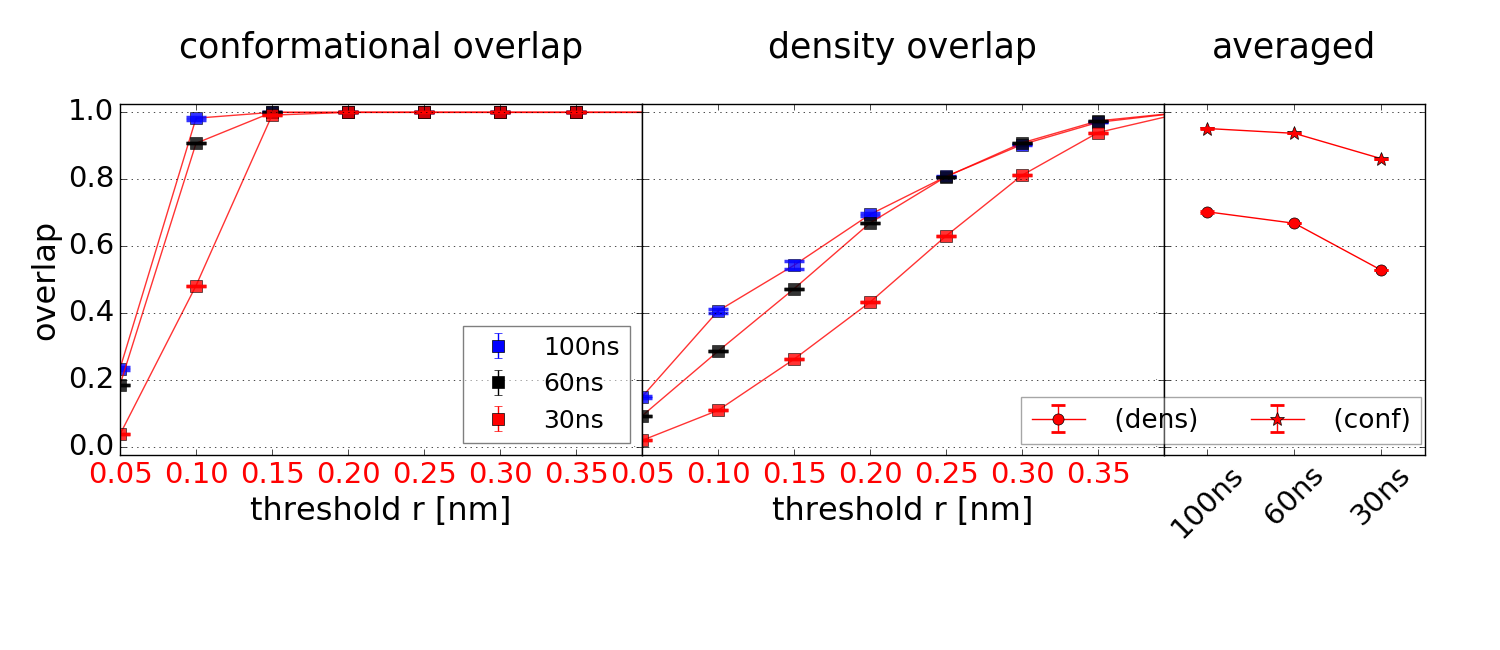

In [4]:
Image(filename='PDFs/Met_Amber_OverlaPvsThreshold.png', width=1000)

##### 2. Heatmap & Dendrogram

The heatmaps represent pair overlap between all trajectories. This is especially useful for massively multiple trajectory comparisons. Here, the values correspond to a threshold of $r=0.15$nm, thus the same values already shown in the Overlap vs Threshold case. Additionally, the number of found clusters for all trajectories can be visualized, if the specific centroid file is submitted.

There is a special option to generate the heatmaps called __AllPrject__ (discussed in the second example below) to show the overlap calculated only for one reference trajectory. Here, the overlap values refer to both reference trajectories (AllPrject="True"), i.e. $K\in L$ and  $O_.(K=\{l_1,l_2\},L=\{l_1,l_2\};r)$ with $l_{1/2}$ are the first or second trajectory, and thus the heatmap is symmetric.

> python ../PySamplingQuality.py -module Plot_HeatMap_1vs1 -in ConfigFiles/Plot_Heat.in

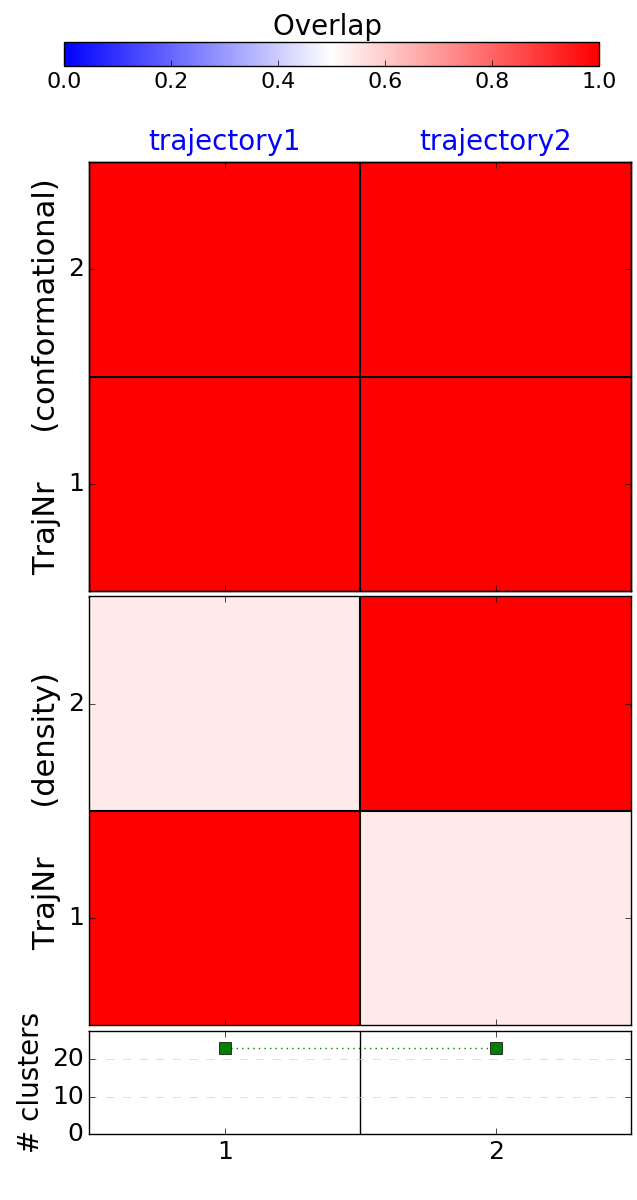

In [21]:
Image(filename='PDFs/Met_Amber_Heat.png', width=300)

The heatmap and corresponding found clusters show, that both trajectories are similar, and the most conformations are found, but the simulation time does not suffice to sample the correct density.

Additionally, the (symmetric) heatmap can be used as input to generate a hierarchically clustered dendrogram using average linkage, to obtain a relation tree representation of the pair overlap.

> python ../PySamplingQuality.py -module Plot_HeatMap_as_Dendro -in ConfigFiles/Plot_Dendro.in

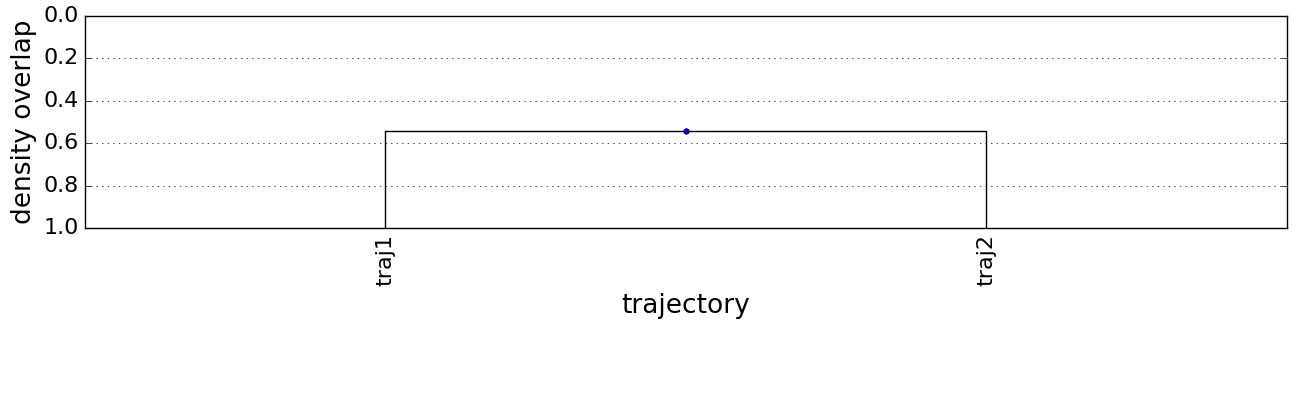

In [22]:
Image(filename='PDFs/Met_Amber_Dendro.png', width=1000)

##### 3. Overlap vs. Time

The overlap as function of the simulation time is a good indicator, if the trajectories and the corresponding sampling already converged or if longer runs are necessary. To investigate this issue, the trajectories were split into three different simulation times 30ns, 60ns and 100ns and plotted for the resolution of $r=0.15$nm. 

One can also select different parts of the trajectories, e.g. the last 30ns by specifying __StartFrame__ in the overlap calculation and in the plotting configuration file.

> python ../PySamplingQuality.py -module Plot_Overlap_VS_Time -in ConfigFiles/Plot_OvT.in

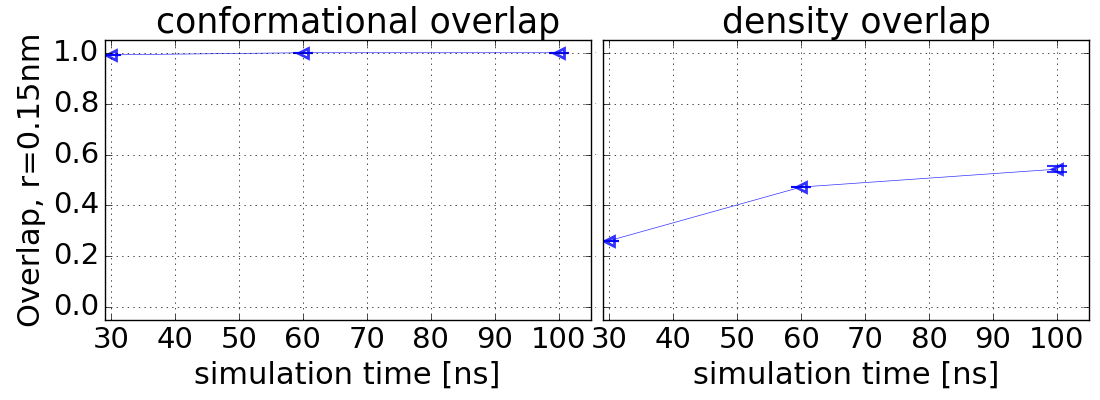

In [5]:
Image('PDFs/Met_Amber_OvT.png', width=1000)

The overlap as function of the simulation time confirms that the most conformations are found, since the conformational overlap is 1. The error bars correspond to the two values for each reference trajectory, discussed above. The density overlap is not converged, yet. Although, the curve seems to slowly converge due to the convex shape, this might be misleading, because using only 60ns may overestimate the density agreement, which can be seen in the event curves above. Thus in general, to obtain a density overlap of one with a high resolution (small $r$) might require very long simulation times, because this overlap value is a conservative measure not to overestimate the sampling quality. It might be sufficient, to obtain a high density overlap for small $r$ (not necessarily of 1) to obtain correct thermodynamic averages.

##### 4. Overlap vs. Number of clusters

The overlap is one indicator, if trajectories sample the same conformational space, but it lacks to give information about the conformational size. Another indicator might be the comparison between the number of found clusters by different trajectories. Thus it is useful to plot for different configurations the overlap as function of the number of clusters found by all trajectories involved in the calculation of the overlap value. 

Here we have only two trajectories, thus we will show the overlap as function of the total number of unique clusters which both trajectories found together.

> python ../PySamplingQuality.py -module Plot_Overlap_VS_Cluster -in ConfigFiles/Plot_OvC.in

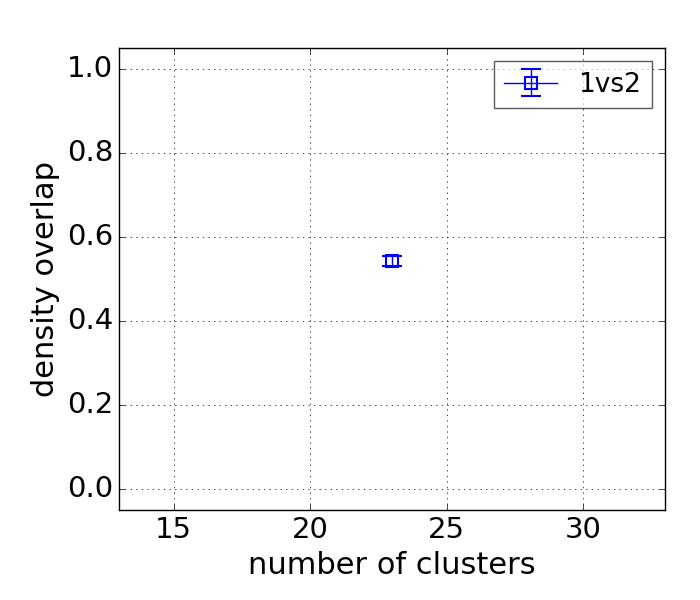

In [16]:
Image('PDFs/Met_Amber_OverlaPvsCluster.png', width=500)

We see, that we found in total 23 unique clusters. If we inspect the clustering file which stores the centroids __Met_Amber_R0.1-0.15_0-1000_Centers_GLOBAL_singles.txt__, we can find out, that already both single trajectories find 23 different clusters. This will be also visualized by the following clustering profile. The error bars correspond to the two values for each reference trajectory, discussed above.

##### 5. Clustering Profile

A clustering profile can be obtained by plotting the clustering centroid as function of the simulation time. This gives insight about the transitions and appearance of different clusters during the course of the simulation. The first and last occurrence of a cluster during the simulation are marked with horizontal lines, squares mark the specific time if the corresponding cluster is visited and white crosses mark the time which the centroid corresponds to.

> python ../PySamplingQuality.py -module Plot_ClusterProfile -in ConfigFiles/Plot_Profile.in

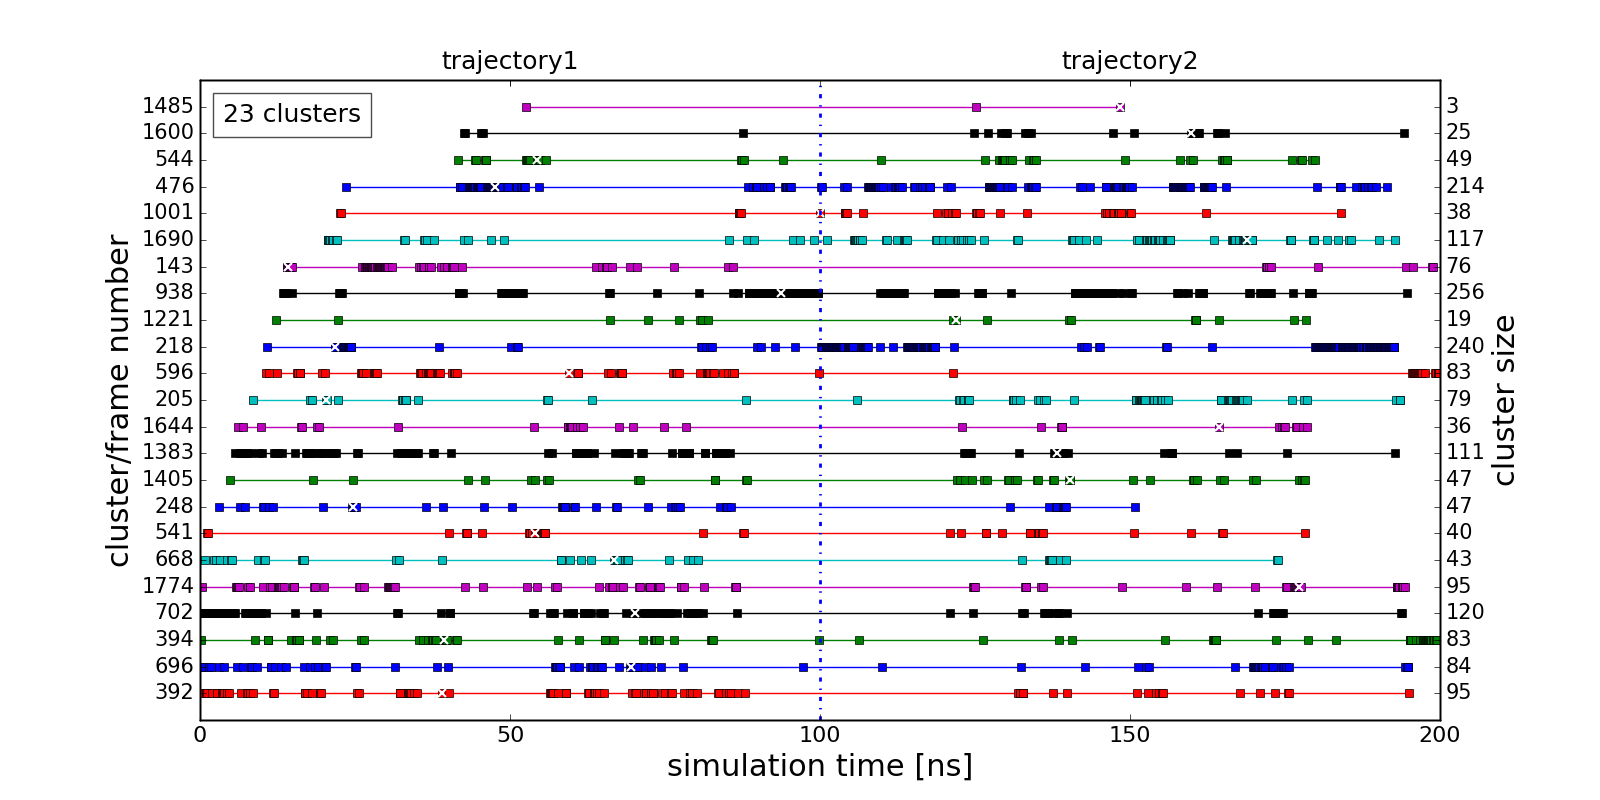

In [18]:
Image('PDFs/Met_Amber_ClusterProfile.png', width=1000)

One can see, that every cluster is found by both trajectories, although the density is not the same. Some clusters are only transition states, whereas others seem to be states with a low potential. But both trajectories expresses different distributions, which could also be shown in the event curves and overlap values.

##### 6. Slopes

The slopes of the number of clusters and CDE as function of time (see above) can be extracted, to compare the tendency finding new clusters or getting a constant entropy value of multiple trajectories at once. 

For the entropy slopes, large negative values indicate, that the trajectory is trapped, because only few of the total number of clusters are sampled for a long time. Large positive values might indicate, that the sampling for one trajectory is incomplete and one should assume to find new clusters for longer simulation times. 

The cluster slopes give insight about, if one should assume to find new clusters for longer simulation times. 

The slopes directly correlate with the __X_NormFactor__ defined above, i.e. in 1000 steps (which means here 100ns) the number of clusters or the CDE raises by the corresponding slope.

> python ../PySamplingQuality.py -module Plot_Slope_Error_Plateau_NrClust -in ConfigFiles/Plot_EntropySlopes.in

> python ../PySamplingQuality.py -module Plot_Slope_Error_Plateau_NrClust -in ConfigFiles/Plot_ClusterSlopes.in

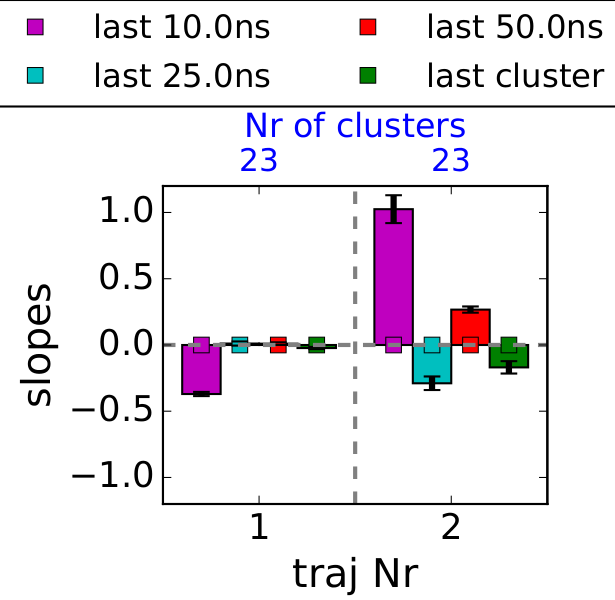

In [19]:
Image('PDFs/EntropySlope_Met_Amber_R0.1-0.15_GLOBAL_singles.png', width=300)

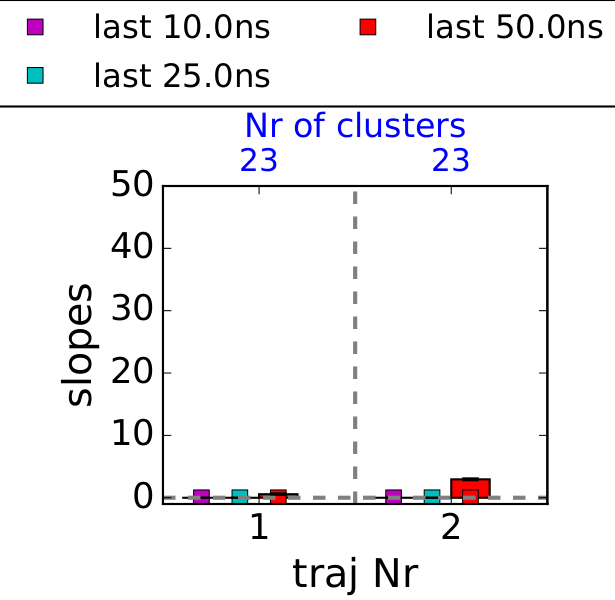

In [20]:
Image('PDFs/ClusterSlope_Met_Amber_R0.1-0.15_GLOBAL_singles.png', width=300)

---

# V. Generate the analysis in IPython

The whole analysis can also be done directly in __python__. For this, we will use this IPython notebook importing all necessary functions, and defining all necessary input options as variables. 

Since all functions are already introduced above, only the necessary parameters are explained.

## 1. Import necessary modules

All necessary modules can be loaded by:

In [6]:
from PySamplingQuality import Generate_RMSD_Matrices
from PySamplingQuality import determineR_using_RMSD_distributions
from PySamplingQuality import Generate_EventCurves
from PySamplingQuality import Calc_Overlap

from PySamplingQuality import Generate_Clustering
from PySamplingQuality import Merge_Clustering_different_Thresholds
from PySamplingQuality import Generate_Centers_GLOBAL_singles
from PySamplingQuality import Generate_CDE_to_File
from PySamplingQuality import Generate_Slope_Error

from PySamplingQuality import Plot_ClusterProfile
from PySamplingQuality import Plot_Slope_Error_Plateau_NrClust
from PySamplingQuality import Plot_Overlap_VS_Threshold
from PySamplingQuality import Plot_HeatMap_1vs1
from PySamplingQuality import Plot_HeatMap_as_Dendro
from PySamplingQuality import Plot_Overlap_VS_Time
from PySamplingQuality import Plot_Overlap_VS_Cluster

For further information about the input options and descriptions, __doc-strings__ can be obtained of the corresponding module, which can be accessed for instance via:

In [7]:
print Generate_RMSD_Matrices.__doc__

 
v22.11.16 
    - using <Generate_RMSD_Matrix()>
    - Calculates every RMSD diagonal & off-diagonal matrix part for <Generate_EventCurves()>
    - needs trajectories in '.xtc', '.trr', '.pdb', '.nc', '.netcdf' or '.dhd' format, then automatically either Gromacs or AmberTools is used
        otherwise, the RMSD matrices can be generated by hand fulfilling the following syntax:
            TrajNameList = [Traj1, Traj2, Traj3, ...] -> Traj1_bin.dat, Traj1_Traj2_bin.dat, ... Traj1_TrajN_bin.dat
                                                         Traj2_bin.dat, Traj2_Traj3_bin.dat, ... Traj2_TrajN_bin.dat
                                                         TrajN_bin.dat
        TrajX_bin.dat       is the self-RMSD-matrix between all frames of trajX
        TrajX_TrajY_bin.dat is the      RMSD-matrix between all frames of trajX vs all frames of trajY                                                            
    - RMSD matrix generation for given Trajectory-List using Gromacs v4

This is the same information, which is also contained in the configuration files.

Furthermore, all default parameters are set automatically, thus they do not need to be specified necessarily.

## 2. Overlap calculation

##### 1. RMSD matrices

The RMSD matrices are generated as before, but now Gromacs trajectories are used.

In [24]:
Generate_RMSD_Matrices(TrajDir='Trajectories/', TopologyDir='Trajectories/', 
                      TrajNameList=['V3_Gromacs1_stripped.xtc', 'V3_Gromacs2_stripped.xtc'], 
                      TopologyName='V3_Gromacs2_stripped.pdb', DistSaveDir='RMSD_distributions2/', 
                      MatrixSaveDir='RMSD_matrices2/', TimeStep=0.1, 
                      Select1='Backbone', Select2='Backbone', 
                      GromacsHome='/home/mike/Software/Gromacs-4.6.7-single/bin/')

The major change is the __TimeStep=0.1__ [ns] value. This means, that every 0.1ns are used starting from the first frame of the trajectory. Because the first frame is also used, there are __1001 frames__, although only 100ns are simulated. This has to be taken into account for the trajectory lengths

Additionally for simplicity, we use as a topology file a PDB structure, thus masses and parameters are automatically detected by the atom names in the PDB file. In general, it is useful to generate a run input file, see the Gromacs manual and syntax. 

Gromacs stores RMSD matrices in binary format, in single precision (float32) or double precision (float64) in one row.

    RMSD_matrices2/V3_Gromacs1_stripped_bin.dat
    RMSD_matrices2/V3_Gromacs2_stripped_bin.dat
    RMSD_matrices2/V3_Gromacs1_stripped_V3_Gromacs2_stripped_bin.dat
    
They can be loaded by e.g. 

    Matrix = numpy.fromfile('RMSD_matrices2/V3_Gromacs1_stripped_bin.dat', dtype='float32')
    
whereas a matrix can be obtained by 

    Matrix = numpy.reshape(Matrix, (LengthX, LengthY)) .

##### 2. RMSD distributions

Gromacs automatically generates also RMSD distributions alongside with the RMSD matrices but they are automatically generated using 100 bins.
    
For different binning (__Bins=250__), we need to generate RMSD distributions anew.

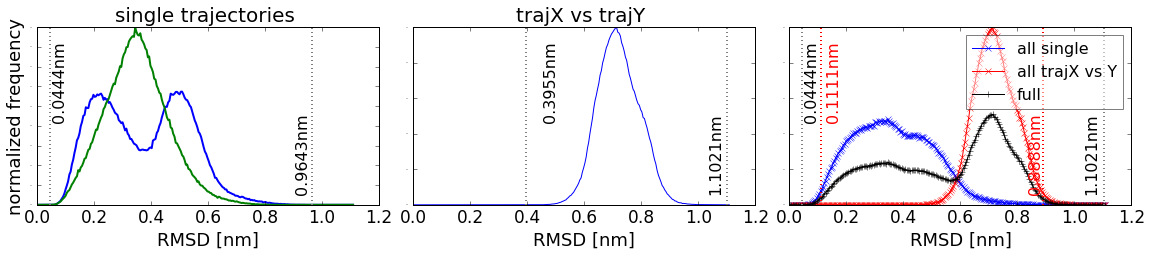

In [25]:
determineR_using_RMSD_distributions(TrajNameList=['V3_Gromacs1_stripped', 'V3_Gromacs2_stripped'], 
                                    SaveName='V3_Gromacs', SaveNamePdf='V3_Gromacs_dist.png', 
                                    SaveDir='RMSD_distributions2/', RMSD_dist_Dir='RMSD_distributions2/', 
                                    MatrixDir='RMSD_matrices2/', BinFile_precision='float32', Bins=250, Percent=0.99)

There is a significant difference between the flexible V3-loop (35aa) and Met-Enkephalin (5aa) in the RMSD distributions of 100ns simulations. Especially, the pair RMSD distribution between the two trajectories are much larger, indicating, that they both sample completely different conformational spaces. 

It is therefore not possible to extract a resolution/threshold $r$ which treat single and pair trajectories in the same fashion. A threshold $r \approx 0.4$nm reflects an average RMSD value for single trajectories, but will automatically result in a very low overlap, since the structures of different trajectories are at least $>0.4$nm away.

##### 3. Generate EventCurves

Here, we will produce event curves again for 100ns, 60ns and 30ns, to analyze the influence of the simulation time. Because Gromacs also uses the first frame by default, the corresponding ending frames must be set to __1001, 601 and 301__, respectively. The same can be applied on the __MaxNumberLines__ value. Then the values can be submitted in a for-loop.

As thresholds, it is recommended to screen through the entire range of RMSD distributions to analyze the overlap as function of the threshold. Thus we use __ThresholdList=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]__ in [nm]

In [26]:
for StartFrame, EndingFrame in [(0,1001), (0,601), (0,301)]:
    Generate_EventCurves(TrajNameList=['V3_Gromacs1_stripped', 'V3_Gromacs2_stripped'], 
                         TrajLengthList=[1001, 1001], 
                         MatrixDir='RMSD_matrices2/', SaveDir='EventCurves2/', SaveName='V3_Gromacs', 
                         ThresholdList=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85], MaxNumberLines=1001, 
                         StartFrame=StartFrame, EndingFrame=EndingFrame, BinFile_precision='float32')

In [27]:
EventCurve2 = numpy.load('EventCurves2/V3_Gromacs_0-1001_noWeight.npy')

print EventCurve2.shape
print EventCurve2

(2002, 18)
[[   0    1    2 ...,  835 1001  987]
 [   1    1    2 ...,  803 1001  985]
 [   2    1    1 ...,  603 1000  855]
 ..., 
 [ 998    2    0 ..., 1001 1001 1001]
 [ 999    2    0 ...,  999  972 1001]
 [1000    2    0 ...,  991  850 1001]]


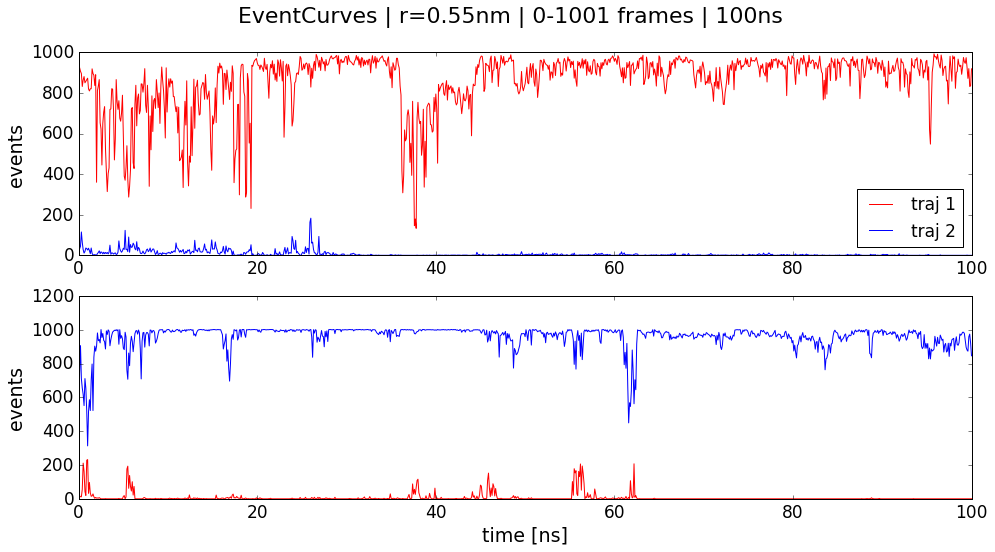

In [28]:
fig = plt.figure(figsize=(16,8));
plt.suptitle('EventCurves | r=0.55nm | 0-1001 frames | 100ns', fontsize=22);
plt.subplot2grid( (2,1), (0,0) );
plt.plot(EventCurve2[0:1001,0]/10., EventCurve2[0:1001,10], 'r-'); plt.yticks(fontsize=17); plt.xticks(fontsize=17);
plt.plot(EventCurve2[0:1001,0]/10., EventCurve2[0:1001,11], 'b-'); plt.ylabel('events', fontsize=19);
plt.legend(['traj 1', 'traj 2'], fontsize=17, loc=0)
plt.subplot2grid( (2,1), (1,0) );
plt.plot(EventCurve2[1001:2002,0]/10., EventCurve2[1001:2002,10], 'r-'); plt.yticks(fontsize=17);
plt.plot(EventCurve2[1001:2002,0]/10., EventCurve2[1001:2002,11], 'b-'); plt.ylabel('events', fontsize=19);
plt.xticks(fontsize=17); plt.xlabel('time [ns]', fontsize=19);

Here, one must use a relatively large threshold $r=0.55$nm, that both trajectories have any event occurrences if one takes the other trajectory as reference. This confirms the outcome from the RMSD distributions discussed above, that the trajectory itself which is also used as reference have almost always all structures in the r-neighborhood $r<0.55$nm. Thus the resolution is too coarse to see the influence of the underlying potential. On the other side, the other trajectory has almost no event, which could be expected by the pair RMSD distribution. Thus the overlap will be (almost) zero.

##### 4. Calculate and plot overlap (conformational | density)

The overlap is easily calculated by submitting the eventcurves by __EventNames__ parameters. Again, the same __CompareList=[([1],[2])]__ is used to calculate only the overlap between both involved trajectories.

Again, the reference groups are the two different trajectories. The conformational overlap for all reference trajectories $K \in L$ is then the sum of __confO__ divided by the sum of __TotFrame__. The corresponding density overlap is the average over all single groups $k$ of __densO__. For $K \subset L$, one can manually decide, for which reference trajectories one wants to calculate or monitor the overlap.

In [10]:
for EventNames in ['V3_Gromacs_0-1001_noWeight.npy', 'V3_Gromacs_0-601_noWeight.npy', 'V3_Gromacs_0-301_noWeight.npy']:
    Calc_Overlap(EventDir='EventCurves2/', EventNames=EventNames, SaveDir='Overlap2/', SaveName='Overlap_V3_Gromacs', 
                 CompareList=[([1],[2])])

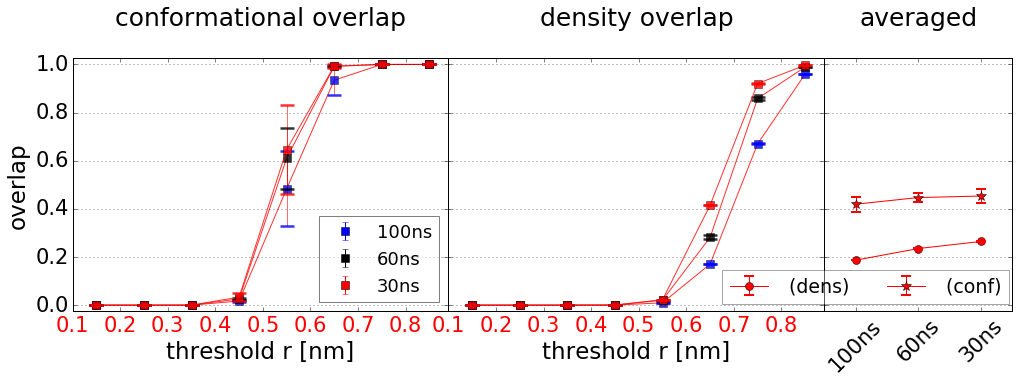

In [11]:
Plot_Overlap_VS_Threshold(OverlapDir='Overlap2/', 
                          OverlapList1=['Overlap_V3_Gromacs_0-1001_noWeight.txt',
                                        'Overlap_V3_Gromacs_0-601_noWeight.txt', 
                                        'Overlap_V3_Gromacs_0-301_noWeight.txt'], 
                          Percentile1=0, Percentile2=100,
                          XLIM1=[0.1, 0.89], LegendList=['100ns', '60ns', '30ns'])

The overlap as function of the threshold expresses the problem discussed above. The overlap has only a non-zero value, if the threshold is set to a large value, where the most structures are trivially in the $r$-neighborhood. Additionally, the insufficient sampling is shown, that for longer simulation times, the overlap is not better, which is of course also shown in the overlap as function of the simulation time. The error bars correspond to the two values for each reference trajectory, discussed above.

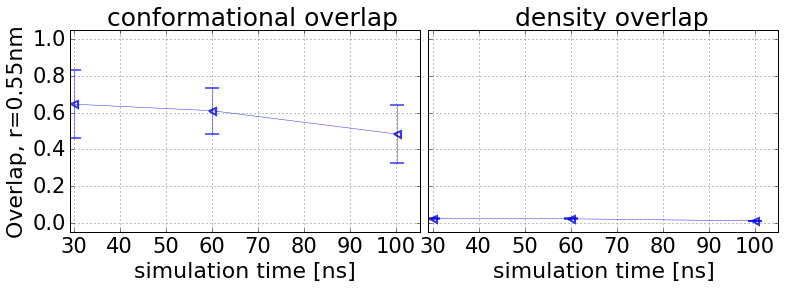

In [12]:
Plot_Overlap_VS_Time(OverlapDir='Overlap2/', OverlapList=['Overlap_V3_Gromacs_Start-End_noWeight.txt'], Threshold=0.55, 
                     SimTimeList=[(0,301), (0,601), (0,1001)], TimeStep=0.1, Percentile1=0, Percentile2=100)

For the heatmap generation, it is possible to set __AllPrject=False__, which then lead to an asymmetric heatmap, where the overlap values are calculated only on one of the corresponding reference trajectories $K$.

In terms of the overlap, it corresponds to two values $O_.(K=\{l_1\},L=\{l_1,l_2\};r)$ and $O_.(K=\{l_2\},L=\{l_1,l_2\};r)$ with $l_{1/2}$ are the first or second trajectory. This gives insight about, how well two trajectories do overlap only in the subset of one, i.e. the lower triangular matrix refers to the overlap XvsY calculated for reference trajectory X, and the upper triangular calculated on reference trajectory Y. 

This is for instance useful, to analyze if one trajectory show a trapped behavior in contrast to others. If a trapped trajectory is used as reference, one obtains a large conformational overlap comparing the trapped with a converged trajectory, because the converged trajectory reaches all the frames of the trapped one. The density overlap will also be larger, in contrast if the converged trajectory is used as reference. This is why both trajectories have to be evaluated as references to conclude, how sufficient the sampling is.

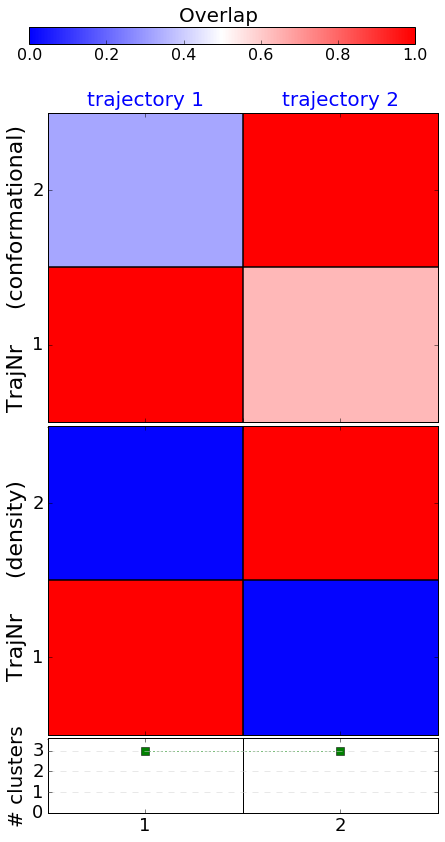

In [13]:
Plot_HeatMap_1vs1(OverlapDir='Overlap2/', FileName='Overlap_V3_Gromacs_0-1001_noWeight.txt', Threshold=0.55, 
                  ClusterDir='Clustering2/', ClusterFileName='V3_Gromacs_R0.2-0.55_0-1001_Centers_LOCAL.txt', 
                  AllPrject=False, Grid=[1], CaseTitles=['trajectory 1', 'trajectory 2'])

The overlap values are low as seen above, even for the taken threshold of $r=0.55$nm. That the threshold is quite large can also be seen that almost all structures are within one cluster, because there are only three clusters found for 1001 structures of a flexible molecule.

Furthermore, one can directly see the impact of the asymmetric heatmap discussed above. If $O_{conf}$ is calculated only for the reference trajectory $l_1$, the overlap is much larger $$O_{conf}\left(K=\{l_1\},L=\{l_1,l_2\};r=0.55\right) = 0.64$$ than calculated for the other reference $$O_{conf}\left(K=\{l_2\},L=\{l_1,l_2\};r=0.55\right) = 0.37 .$$
One can directly conclude, that the first trajectory $l_1$ sample almost 2 third the same conformational space of the second trajectory, thus the sampled conformational space reached is in general smaller compared to the second trajectory.



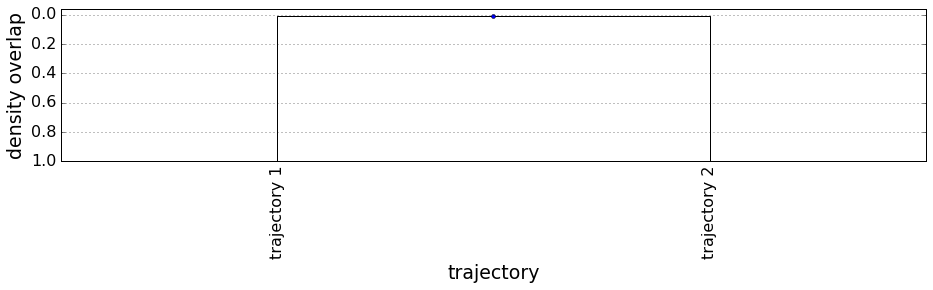

In [14]:
Plot_HeatMap_as_Dendro(OverlapDir='Overlap2/', FileName='Overlap_V3_Gromacs_0-1001_noWeight.txt', Threshold=0.55, 
                       Case='density', Labels=['trajectory 1', 'trajectory 2'])

## 3. Clustering

##### 1. Generate the clustering, merge different thresholds and plot the clustering profile

The clustering will this time be done locally for every trajectory separately (__GLOBAL=False__). Additionally, no reference structure is inserted thus the first frame of the corresponding trajectory is taken as the first centroid. This means, in general the clusterings are not 100% comparable, but still one can analyze the different behavior for instance in the clustering profile.

In [36]:
for Threshold in [0.2, 0.4, 0.55]:
    Generate_Clustering(MatrixDir='RMSD_matrices2/', SaveDir='Clustering2/', 
                        TrajNameList=['V3_Gromacs1_stripped', 'V3_Gromacs2_stripped'], 
                        TrajLengthList=[1001,1001], Threshold=Threshold, SaveName='V3_Gromacs', 
                        MaxNumberLines=1001, TimeStep=0.1, GLOBAL=False, BinFile_precision='float32')

In [37]:
Merge_Clustering_different_Thresholds(SingleClustDir='Clustering2/', SaveDir='Clustering2/',
                                      SaveName='V3_Gromacs', ThresholdList=[0.2, 0.4, 0.55], 
                                      StartFrame=0, EndingFrame=1001, GLOBAL=False)

In the clustering profile, one can see, that indeed the clustering starts with the first structure for both trajectories. 

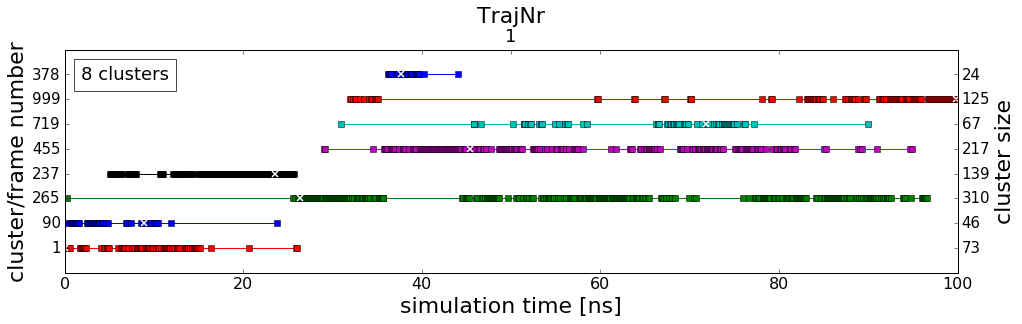

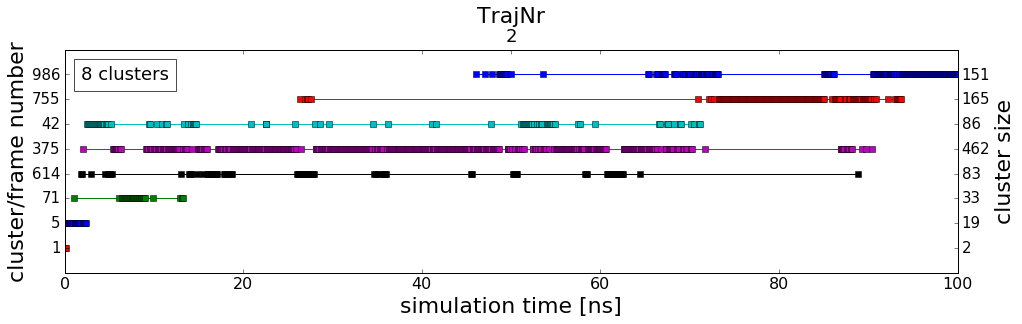

In [41]:
Plot_ClusterProfile(ClusterDir='Clustering2/', ClusterName='V3_Gromacs_R0.2-0.55_0-1001_LOCAL.txt', Global=False,
                    TimeStep=0.1, Threshold=0.4, TrjLenList=[100,100], FigSize=[16,4])

But there is a clear difference between both trajectories, where the first trajectory is almost split around 27ns into two parts, the second trajectory immediately leave the starting structure and predominantly stays a long time in one cluster.

In this example, we are not able to plot the overlap as function of the number of unique clusters, because we generated a local clustering for both trajectories. This means, that each trajectory is clustered separately, and thus the partitioning is not 100% comparable, thus one cannot find the unique clusters which will be found by both trajectories together.

##### 2. Calculate the cluster distribution entropy (CDE) and the number of clusters found as function of the simulation time

The cluster distribution entropy can be directly calculated from the single trajectory clustering without extracting the clustering from a global partitioning as done above. The only change comparing to the Met-Enkephalin molecule is the case parameter, which is set to __Case='LOCAL'__, because local clustering was done.

In [42]:
Generate_CDE_to_File(ClusterDir='Clustering2/', ClusterFileName='V3_Gromacs_R0.2-0.55_0-1001_LOCAL.txt', 
                     ThresholdList=[0.2, 0.4, 0.55], Case='LOCAL', SaveDir='Clustering2/', 
                     SaveName='CDE_V3_Gromacs_R0.2-0.55')

Here, we show the number of found clusters and the cluster distribution entropy over the course of the simulation time for $r=0.4$nm, which corresponds to the sixth and eighth column of the CDE file.

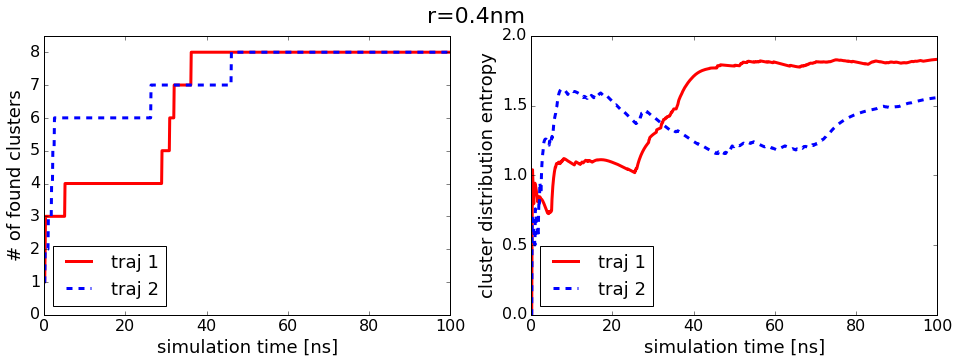

In [6]:
CDE2 = numpy.genfromtxt('Clustering2/CDE_V3_Gromacs_R0.2-0.55_LOCAL.txt')

fig = plt.figure(figsize=(16,5))
#-----
plt.subplot2grid( (1,2), (0,0) ); plt.suptitle('r=0.4nm', fontsize=22)
plt.plot(CDE2[0:1001,0]/10., CDE2[0:1001,6], 'r-', lw=3); plt.plot(CDE2[0:1001, 0]/10., CDE2[1001:2002,6], 'b--', lw=3);
plt.xlabel('simulation time [ns]', fontsize=18); plt.ylabel('# of found clusters', fontsize=18); plt.ylim([0,8.5])
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.legend(['traj 1', 'traj 2'], fontsize=18, loc=0);
#-----
plt.subplot2grid( (1,2), (0,1) )
plt.plot(CDE2[0:1001,0]/10., CDE2[0:1001,8], 'r-', lw=3); plt.plot(CDE2[0:1001, 0]/10., CDE2[1001:2002,8], 'b--', lw=3); 
plt.xlabel('simulation time [ns]', fontsize=18); plt.ylabel('cluster distribution entropy', fontsize=18); 
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.legend(['traj 1', 'traj 2'], fontsize=18, loc=0);

The number of found cluster indicates wrongly, that the sampling could be converged and all clusters are already found, which could be seen in the overlap analysis. Only the entropy for the second trajectory indicates, that the sampling is insufficient. Therefore, it is necessary not only to rely on single trajectory approaches.

##### 3. Investigate and plot the slopes

The corresponding slopes can be extracted by the following function:

In [44]:
Generate_Slope_Error(EntropyDir='Clustering2/', EntropyName='CDE_V3_Gromacs_R0.2-0.55_LOCAL.txt', 
                     SaveDir='Clustering2/', SaveName='Slope_V3_Gromacs_R0.2-0.55')

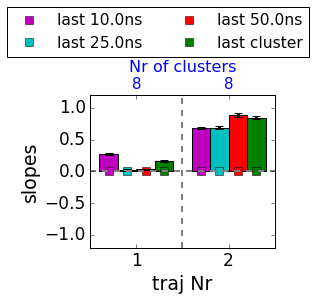

In [45]:
Plot_Slope_Error_Plateau_NrClust(SlopeDir='Clustering2/', SlopeName='Slope_V3_Gromacs_R0.2-0.55_LOCAL.txt', 
                                 Threshold=0.4, Case='Entropy', TimeStep=0.1)

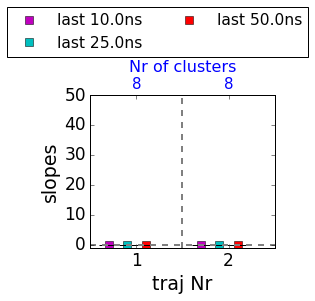

In [46]:
Plot_Slope_Error_Plateau_NrClust(SlopeDIR='Clustering2/', SlopeName='Slope_V3_Gromacs_R0.2-0.55_LOCAL.txt', 
                                 Threshold=0.4, Case='Cluster', TimeStep=0.1)

They give a condensed information about the behavior which was already discussed.

----

# VI. Protein-ligand systems or complexes

The focus of the tool presented here is to classify the sampling quality using a multi-trajectory approach. It is based on identifying identical/similar structures within a certain resolution, which is given by a threshold parameter $r$ based on RMSD values. Identifying similar structures, it is possible to extract the densities of these conformations, which must be similar/identical to each other for different trajectories if the sampling is sufficient respectively the same.

This principle must also be true for more complicated systems involving multiple proteins or protein-ligand complexes. But especially for protein-ligand systems, it might be more interesting to analyze the ligand binding positions and the binding conformations of the ligand, than for instance only the ligand conformation similarity alone.

This idea is illustrated in the following figure:

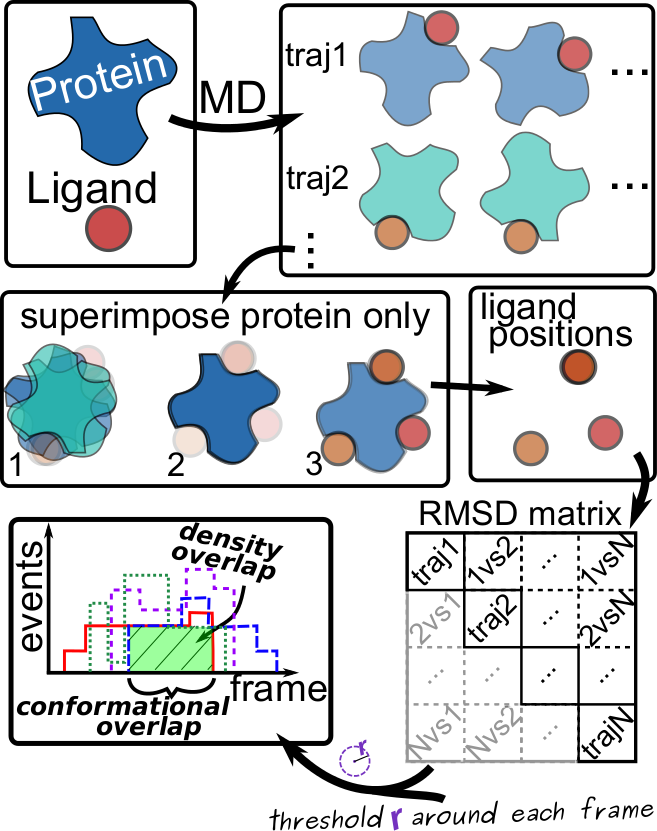

In [2]:
Image('ProteinLigand.png', width=500)

One can assess the sampling quality of such a protein-ligand system by inserting an intermediate step before the RMSD matrix generation. The trajectories must be superimposed by fitting the whole system only on relevant atoms of the protein, like the heavy atoms of the backbone or the $C_{\alpha}$-atoms. Afterwards, the protein must be stripped from the trajectories and only the absolute positions of the ligands are kept. __These steps are not part of the PySamplingQuality.py__ as the program awaits pre-processed trajectories as input. Thus the superimposing and ligand extraction must be done manually, similar to water, cap extraction or periodic boundary handling mentioned above. 

After these preparation steps, the RMSD matrix generation can again be done using __Generate_RMSD_Matrices()__ (for Gromacs or Amber trajectories or PDB files) by setting the parameter __Fit="None"__. This ensures, that no further fitting is done and the absolute distances of the ligands are kept. 

The following steps are the same. 

Now each reference frame corresponds also to the ligand position in the system. It is possible to select two different resolution schemes by the threshold parameter $r$:

1. Setting $r$ to a (very) small value, one obtains additionally the effect of different binding conformations of the ligands, because the ligands must simultaneously fulfill the same position and also the shape to express an overlap within an $r$-neighborhood. If the positions are identical, but some ligands are shifted or bind with different residues, the RMSD values between different binding conformations at the same pocket will be large, and thus one will detect, that these binding conformations are not similar.
1. Setting $A < r < B$ to an intermediate value, where $A$ means the variation of binding conformations at one binding pocket and $B$ corresponds to the (smallest) RMSD value between different binding pockets, one will only investigate, if different trajectories find the same binding pockets with the same probability density. Normally, $A \ll B$ should be true for most systems. This tackles another question of the protein-binding process.

Finally, it is surely possible to investigate the overlap between different ligands in protein-ligand systems. This answers the question, if different ligands behave similar to each other (large overlap) or have totally different binding properties (no overlap). Surely, one has to first ensure that both systems are sufficiently sampled separately.

It has to be mentioned, that comparing complexes with different ligands requires a relatively stable protein which does not change a lot upon binding (see induced fit [Koshland PNAS 44 1958]). Otherwise there will automatically be a shift in the RMSD values due to significant deviations between the protein and binding pocket positions. This will then naturally lead to a poor overlap.

---

# VII. Summary & Outlook

The analysis aims to investigate Molecular Dynamics (MD) simulation sampling using multiple trajectories. This allows to access the sampling quality with multiple criteria

1. clustering
    - number of clusters
    - cluster distribution entropy
1. overlap
    - conformational overlap
    - density overlap
    
and decide, if the simulation converged and the sampling is sufficient (self-consistency). The analysis is based on a distance like matrix, whereas RMSD values are used. 

It is recommended to use multiple trajectories with multiple different conditions, for instance different starting conformations, different velocity seeds and similar. The more trajectories are used, the less probable is to sample only a small amount of the conformational space and run into the "unknown unknowns" problem not reaching slowly relaxing degrees of freedom [Romo & Grossfield - Biophys. J. 106 2014].

Theoretically, it is possible to use the analysis also on a totally different problem:

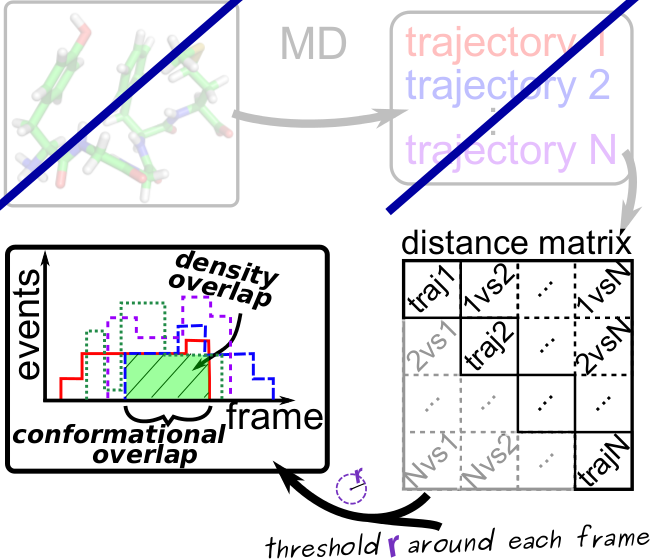

In [5]:
Image('OverlapCalculation_starting_with_RMSD.png', width=500)

The necessary observables of another scientific question need to be transformed into distance based block matrices. Then the analysis could start with an own distance-based measure calculating the self-consistency and overlap between multiple different systems.